In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats 
from scipy.stats import shapiro

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, classification_report, plot_confusion_matrix,f1_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split , cross_val_predict, cross_val_score ,StratifiedKFold , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_selection import SelectFromModel

import shap

# INSERTION DES DATAFRAMES.

### Introduction de df_2020, qui va nous servir à définir notre target.

In [2]:
df_2020 = pd.read_csv('2020_US_County_Level_Presidential_Results.csv')
df_2020=pd.DataFrame(df_2020)
df_2020['years']=2020
df_2020

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,years
0,Alabama,1001,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,2020
1,Alabama,1003,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,2020
2,Alabama,1005,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,2020
3,Alabama,1007,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,2020
4,Alabama,1009,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,2020
...,...,...,...,...,...,...,...,...,...,...,...
3147,Wyoming,56037,Sweetwater County,12229,3823,16603,8406,0.736554,0.230260,0.506294,2020
3148,Wyoming,56039,Teton County,4341,9848,14677,-5507,0.295769,0.670982,-0.375213,2020
3149,Wyoming,56041,Uinta County,7496,1591,9402,5905,0.797277,0.169219,0.628058,2020
3150,Wyoming,56043,Washakie County,3245,651,4012,2594,0.808824,0.162263,0.646560,2020


### Recherche des données manquantes. 

In [3]:
df_2020.isna().sum()

state_name        0
county_fips       0
county_name       0
votes_gop         0
votes_dem         0
total_votes       0
diff              0
per_gop           0
per_dem           0
per_point_diff    0
years             0
dtype: int64

### Représentation du nombre d'observation par états.

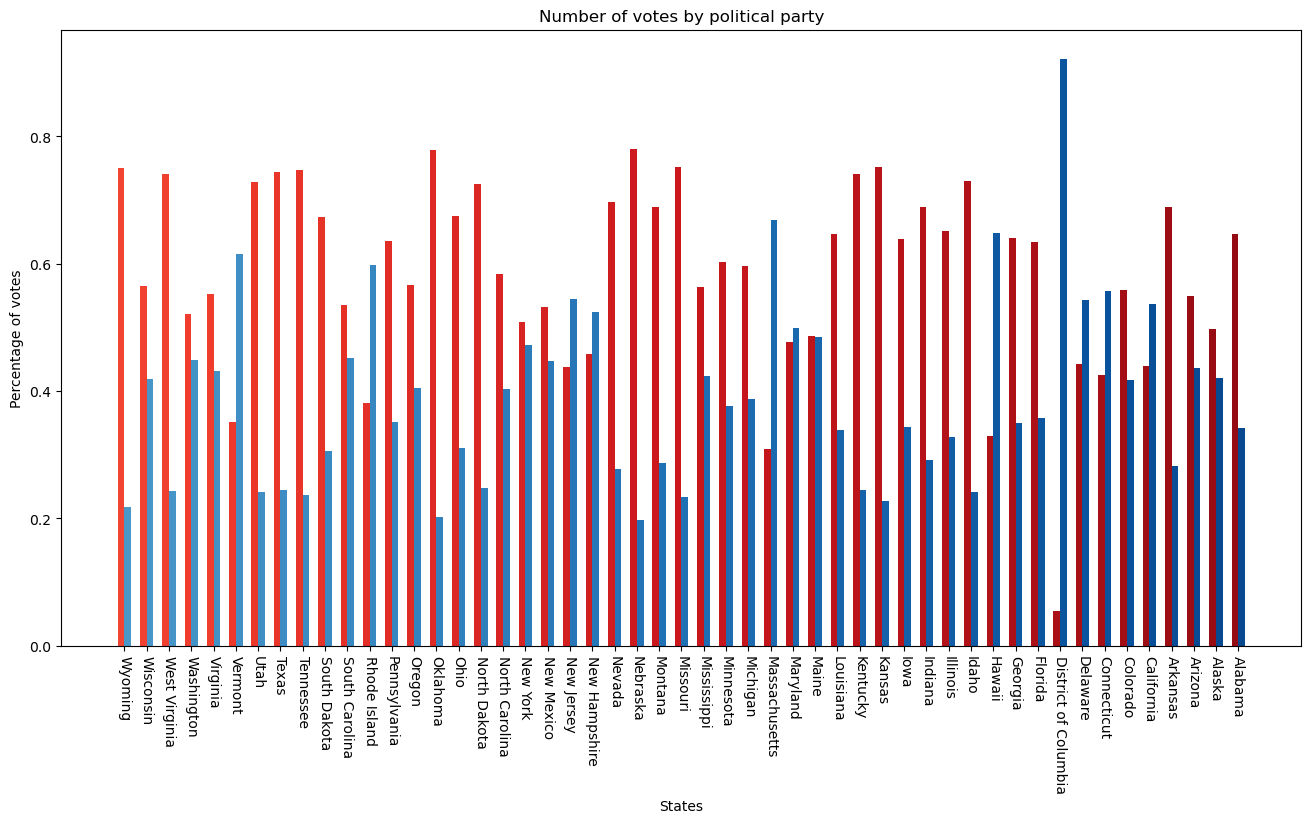

In [4]:
#pourcentages de votes par états :
color_1 = plt.cm.Reds(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Blues(np.linspace(0.6, 1, 66))

states = df_2020.groupby('state_name').agg({'per_gop':'mean',
                                  'per_dem':'mean'}).sort_values(by='state_name',ascending=False)

data1 = states['per_gop']
data2 = states['per_dem']

plt.figure(figsize=(16,8))
x = np.arange(51)
ax1 = plt.subplot(1,1,1)
w = 0.3

color = color_1
plt.title('Number of votes by political party')
plt.xticks(x + w /2, data1.index, rotation=-90)
ax1.set_xlabel('States')
ax1.set_ylabel('Percentage of votes')
ax1.bar(x,data1.values,color=color_1,width=w,align='center')

color = color_2
ax2 = ax1
ax2.bar(x + w,data2, color=color_2,width=w,align='center')

plt.show()

### Encodage de notre target. 

Comme il est prévu par l'énoncé, nous créons notre target qui contient 1 si les républicains gagnent et 0 si ce sont les démocrates.

In [5]:
df_2020['target'] = np.where(df_2020['votes_gop']>df_2020['votes_dem'], '1', '0 ')

In [6]:
df_2020['target'].value_counts()

1     2595
0      557
Name: target, dtype: int64

### Standardisation des intitulés des colonnes "code postale", "nom de l'états" et "nom de l'aire urbaine".

NB: nous effectuons cette standardisation des colonnes pour les dataframes ou ces intitulés sont différends.
Ces 3 colonnes vont fusionner lorsque l'on va concaténer nos données.

In [7]:
df_2020.rename(columns={"county_fips": "FIPS Code",'county_name':'Area name'}, inplace=True)

### Suppression des colonnes non nécéssaires.
Je ne regarde que notre target et total_votes, la colonne total_votes va nous servir à effectuer du feature engineering et créer une variable de participation. 

In [8]:
df_2020.drop(columns=['state_name','votes_gop','votes_dem','diff','per_gop','per_dem','per_point_diff','years'],inplace=True) 
df_2020.head()

,FIPS Code,Area name,total_votes,target
0,1001,Autauga County,27770,1
1,1003,Baldwin County,109679,1
2,1005,Barbour County,10518,1
3,1007,Bibb County,9595,1
4,1009,Blount County,27588,1


# Introduction de df_educ

### Insertion des données.

In [9]:
df_educ = pd.read_excel('Education.xls',skiprows=4)
df_educ = pd.DataFrame(df_educ)
df_educ.head()

,FIPS Code,State,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970",...,"Percent of adults completing some college or associate's degree, 2000","Percent of adults with a bachelor's degree or higher, 2000","Less than a high school diploma, 2015-19","High school diploma only, 2015-19","Some college or associate's degree, 2015-19","Bachelor's degree or higher, 2015-19","Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19"
0,0,US,United States,NaN,NaN,NaN,NaN,52373312.0,34158051.0,11650730.0,...,27.4,24.4,26472261.0,59472748.0,63756905.0,70920162.0,11.998918,26.956844,28.898697,32.145542
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,1062306.0,468269.0,136287.0,...,25.9,19.0,458922.0,1022839.0,993344.0,845772.0,13.819302,30.800268,29.912098,25.468332
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,6611.0,3757.0,933.0,...,26.9,18.0,4291.0,12551.0,10596.0,9929.0,11.483395,33.588459,28.356571,26.571573
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,18726.0,8426.0,2334.0,...,29.3,23.1,13893.0,41797.0,47274.0,48148.0,9.193843,27.659616,31.284081,31.862459
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,8120.0,2242.0,581.0,...,21.3,10.9,4812.0,6396.0,4676.0,2080.0,26.786907,35.604542,26.029837,11.578713


### Visualisation des valeurs manquantes.

<AxesSubplot: >

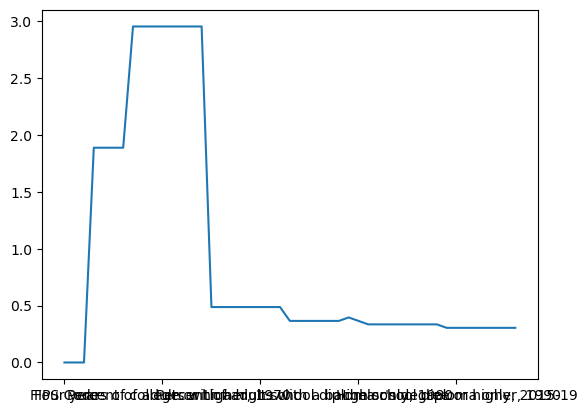

In [10]:
x=df_educ.isna().sum()/len(df_educ)*100
x.plot()

### Suppression des valeurs manquantes.

In [11]:
df_educ=df_educ.dropna()

Cette Data frame contient les données sur les différends niveaux d'éducation aux états-unis.
Les niveaux d'études sont classés en 4 catégories, ces niveaux d'études sont données en valeur relative et en pourcentage, les catégories d'études sont :

-niveau inférieur au bac, niveau bac, niveau d'étude supérieur compris entre 1 et 3 ans après le baccalauréat et le niveau d'étude supérieure à la licence. 

On ne gardera donc que les données de ces 4 catégories pour l'année 2015-2019. 
En effet, les variables concernant 1970,1980,1990,2000, ne permettent pas de créer un indicateur de l'évolution de l'éducation les années
du mandat présidentiel.

En observant les données, on remarque que les intitulés de certains niveaux d'étude ne sont pas les mêmes en 1970, 1980 que pour les données de 1990,
2000 ou 2015-19. 
On crée donc une fonction afin de standardiser les intitulés (via la fonction educrename ).
Une fois que les intitutilés des colonnes sont les mêmes, on peut effacer les années qui ne servent pas à l'étude, 
via la création et l'application de fonction educyearsupprfct. 

Une fois ces opérations terminées, on obtient nos 4 catégories d'étude en pourcentage et en valeur absolue, on devra donc supprimer les valeurs absolue 
pour obtenir notre dataframe final.

### Création et application de la fonction educrename pour standardiser les intitulés des colonnes au sein de la dataframe.

In [12]:
def educrename (year) :
    df_educ.rename(columns={f"Some college (1-3 years), {year}":f"Some college or associate's degree, {year}",
                        f"Percent of adults completing some college (1-3 years), {year}":f"Percent of adults completing some college or associate's degree, {year}",
                        f"Four years college or higher, {year}":f"Bachelor's degree or higher, {year}",
                        f"Percent of adults completing four years of college or higher, {year}":f"Percent of adults with a bachelor's degree or higher, {year}",
                        f"Four years of college or higher, {year}":f"Bachelor's degree or higher, {year}"},
               inplace=True)
               

In [13]:
educrename (1970)
educrename (1980)

### Création et application de la fonction educyearsupprfct pour supprimer les variables des années non souhaitées.

In [14]:
def educyearsupprfct (year):
    df_educ.drop(columns=[f'Less than a high school diploma, {year}',f'High school diploma only, {year}',f"Some college or associate's degree, {year}",
                          f"Bachelor's degree or higher, {year}",f"Percent of adults with less than a high school diploma, {year}",
                          f"Percent of adults with a high school diploma only, {year}",f"Percent of adults completing some college or associate's degree, {year}",
                          f"Percent of adults with a bachelor's degree or higher, {year}"], 
             inplace=True)

In [15]:
list_years = ['1970','1980','1990','2000'] 
for i in list_years:
    educyearsupprfct (i)

### Suppression des données relatives pour ne garder que celles en pourcentage + suppression des colonnes sur le taux d'urbanisme de 2003  

In [16]:
df_educ.drop(columns=["Less than a high school diploma, 2015-19","High school diploma only, 2015-19","Some college or associate's degree, 2015-19",
                      "Bachelor's degree or higher, 2015-19","2003 Rural-urban Continuum Code","2003 Urban Influence Code"],
             inplace=True)

### Aperçu de la dataframe finale.

In [17]:
df_educ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3125 entries, 2 to 3203
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   FIPS Code                                                                 3125 non-null   int64  
 1   State                                                                     3125 non-null   object 
 2   Area name                                                                 3125 non-null   object 
 3   2013 Rural-urban Continuum Code                                           3125 non-null   float64
 4   2013 Urban Influence Code                                                 3125 non-null   float64
 5   Percent of adults with less than a high school diploma, 2015-19           3125 non-null   float64
 6   Percent of adults with a high school diploma only, 2015-19       

In [18]:
df_educ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3125 entries, 2 to 3203
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   FIPS Code                                                                 3125 non-null   int64  
 1   State                                                                     3125 non-null   object 
 2   Area name                                                                 3125 non-null   object 
 3   2013 Rural-urban Continuum Code                                           3125 non-null   float64
 4   2013 Urban Influence Code                                                 3125 non-null   float64
 5   Percent of adults with less than a high school diploma, 2015-19           3125 non-null   float64
 6   Percent of adults with a high school diploma only, 2015-19       

# Introduction de la dataframe df_pop

### Insertion des données 

In [19]:
df_pop = pd.read_excel('PopulationEstimates.xls',skiprows=2)
df_pop = pd.DataFrame(df_pop)

### Visualisation des valeurs manquantes.

<AxesSubplot: >

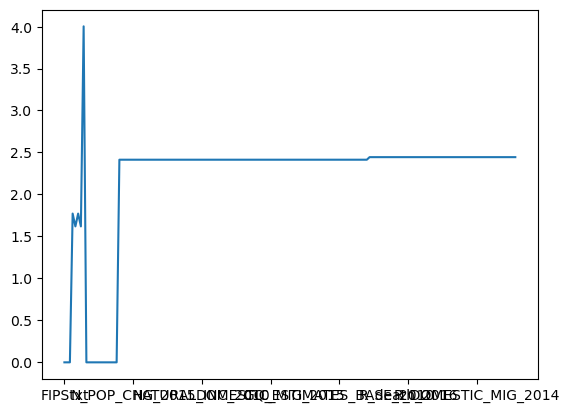

In [20]:
x=df_pop.isna().sum()/len(df_pop)*100
x.plot()

### Suppression des données manquantes. 

In [21]:
df_pop.dropna(inplace=True)

### Visualisation des colonnes de df_pop

In [22]:
x=df_pop.columns
x[:50]

Index(['FIPStxt', 'State', 'Area_Name', 'Rural-urban_Continuum Code_2003',
       'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2003',
       'Urban_Influence_Code_2013', 'Economic_typology_2015',
       'CENSUS_2010_POP', 'ESTIMATES_BASE_2010', 'POP_ESTIMATE_2010',
       'POP_ESTIMATE_2011', 'POP_ESTIMATE_2012', 'POP_ESTIMATE_2013',
       'POP_ESTIMATE_2014', 'POP_ESTIMATE_2015', 'POP_ESTIMATE_2016',
       'POP_ESTIMATE_2017', 'POP_ESTIMATE_2018', 'POP_ESTIMATE_2019',
       'N_POP_CHG_2010', 'N_POP_CHG_2011', 'N_POP_CHG_2012', 'N_POP_CHG_2013',
       'N_POP_CHG_2014', 'N_POP_CHG_2015', 'N_POP_CHG_2016', 'N_POP_CHG_2017',
       'N_POP_CHG_2018', 'N_POP_CHG_2019', 'Births_2010', 'Births_2011',
       'Births_2012', 'Births_2013', 'Births_2014', 'Births_2015',
       'Births_2016', 'Births_2017', 'Births_2018', 'Births_2019',
       'Deaths_2010', 'Deaths_2011', 'Deaths_2012', 'Deaths_2013',
       'Deaths_2014', 'Deaths_2015', 'Deaths_2016', 'Deaths_2017',
       'Death

In [23]:
x[50:100]

Index(['NATURAL_INC_2010', 'NATURAL_INC_2011', 'NATURAL_INC_2012',
       'NATURAL_INC_2013', 'NATURAL_INC_2014', 'NATURAL_INC_2015',
       'NATURAL_INC_2016', 'NATURAL_INC_2017', 'NATURAL_INC_2018',
       'NATURAL_INC_2019', 'INTERNATIONAL_MIG_2010', 'INTERNATIONAL_MIG_2011',
       'INTERNATIONAL_MIG_2012', 'INTERNATIONAL_MIG_2013',
       'INTERNATIONAL_MIG_2014', 'INTERNATIONAL_MIG_2015',
       'INTERNATIONAL_MIG_2016', 'INTERNATIONAL_MIG_2017',
       'INTERNATIONAL_MIG_2018', 'INTERNATIONAL_MIG_2019', 'DOMESTIC_MIG_2010',
       'DOMESTIC_MIG_2011', 'DOMESTIC_MIG_2012', 'DOMESTIC_MIG_2013',
       'DOMESTIC_MIG_2014', 'DOMESTIC_MIG_2015', 'DOMESTIC_MIG_2016',
       'DOMESTIC_MIG_2017', 'DOMESTIC_MIG_2018', 'DOMESTIC_MIG_2019',
       'NET_MIG_2010', 'NET_MIG_2011', 'NET_MIG_2012', 'NET_MIG_2013',
       'NET_MIG_2014', 'NET_MIG_2015', 'NET_MIG_2016', 'NET_MIG_2017',
       'NET_MIG_2018', 'NET_MIG_2019', 'RESIDUAL_2010', 'RESIDUAL_2011',
       'RESIDUAL_2012', 'RESIDUAL_2013

In [24]:
x[100:]

Index(['GQ_ESTIMATES_BASE_2010', 'GQ_ESTIMATES_2010', 'GQ_ESTIMATES_2011',
       'GQ_ESTIMATES_2012', 'GQ_ESTIMATES_2013', 'GQ_ESTIMATES_2014',
       'GQ_ESTIMATES_2015', 'GQ_ESTIMATES_2016', 'GQ_ESTIMATES_2017',
       'GQ_ESTIMATES_2018', 'GQ_ESTIMATES_2019', 'R_birth_2011',
       'R_birth_2012', 'R_birth_2013', 'R_birth_2014', 'R_birth_2015',
       'R_birth_2016', 'R_birth_2017', 'R_birth_2018', 'R_birth_2019',
       'R_death_2011', 'R_death_2012', 'R_death_2013', 'R_death_2014',
       'R_death_2015', 'R_death_2016', 'R_death_2017', 'R_death_2018',
       'R_death_2019', 'R_NATURAL_INC_2011', 'R_NATURAL_INC_2012',
       'R_NATURAL_INC_2013', 'R_NATURAL_INC_2014', 'R_NATURAL_INC_2015',
       'R_NATURAL_INC_2016', 'R_NATURAL_INC_2017', 'R_NATURAL_INC_2018',
       'R_NATURAL_INC_2019', 'R_INTERNATIONAL_MIG_2011',
       'R_INTERNATIONAL_MIG_2012', 'R_INTERNATIONAL_MIG_2013',
       'R_INTERNATIONAL_MIG_2014', 'R_INTERNATIONAL_MIG_2015',
       'R_INTERNATIONAL_MIG_2016', 'R_IN

Cette dataframe représente la population, elle contient la population estimée, l'évolution de la population, le nombre de personnes décédées, le nombre
de naissance, le taux de croissance naturelle, les migrations domestiques, les migrations internationales et la migration net.  
Puis on à les mêmes données mais en réel.
On va utiliser les données réels, on va donc garder le taux de croissance naturelle (qui comprend les informations sur le nombre de décéset de naissance),
le taux de migration internationale, le taux de migration domestique et la population. Ainsi on pourra capturer les informations sur le dynamisme d'une région.  

### Création et application de la fonction datapopsuppr pour supprimer les variables qui ne plus utiles.

In [25]:
list_year=['2011','2012','2013','2014','2015','2016','2017','2018','2019']

In [26]:
def datapopsuppr (year):
    df_pop.drop(columns=[f"N_POP_CHG_{year}",f"Births_{year}",f"Deaths_{year}",f"NATURAL_INC_{year}",f"INTERNATIONAL_MIG_{year}",f'DOMESTIC_MIG_{year}',f'NET_MIG_{year}',
                       f'RESIDUAL_{year}',f'GQ_ESTIMATES_{year}',f'R_birth_{year}',f'R_death_{year}',f"R_NET_MIG_{year}"],
              inplace=True)

In [27]:
for i in list_year:
    datapopsuppr (i)

### Suppression des variables de 2010 et des variables d'urbanisme.

Pour l'année 2010, il manque certaines colonnes comparativement aux autres années.
On ne peut donc pas appliquer la fonction datapopsuppr pour cette année. On va donc supprimer ces données manuellement.
On va ensuite supprimer les variables liées aux taux de ruralité ou d'urbanisme, qui sont présentes dans d'autres dataframes, on va aussi supprimer la 
variable Economic Typology dont on ne connait pas la signification. 

In [28]:
df_pop.drop(columns=["N_POP_CHG_2010","Births_2010","Deaths_2010","NATURAL_INC_2010","INTERNATIONAL_MIG_2010",'DOMESTIC_MIG_2010','NET_MIG_2010','RESIDUAL_2010',
                     'GQ_ESTIMATES_2010','GQ_ESTIMATES_BASE_2010','CENSUS_2010_POP','ESTIMATES_BASE_2010','POP_ESTIMATE_2010','Economic_typology_2015'],
            inplace=True)

In [29]:
df_pop.drop(columns=['Rural-urban_Continuum Code_2003','Urban_Influence_Code_2003','Rural-urban_Continuum Code_2013','Urban_Influence_Code_2013'], inplace=True)

Pour l'étude, on ne va garder que les données de 2015 et 2019. On a cependant besoin des variables de toutes les années 
afin d'effectuer le feature engineering.
On effectue donc le feature engineering avant de nettoyer complètement df_pop.

### DF_POP FEATURE ENGINEERING

Avoir la même variable, mais sur différentes années dans nos données introduis de l'autocorrélation entre ces variables.
Cependant, pour capter l'évolution de cette variable dans le temps, sans avoir d'autocorrélation, nous allons créer une nouvelle variable. 
Une variable qui reprend l'évolution annuelle moyenne au cours des 4 années du cycle présidentiel donc de 2012-2015 et de 2016 à 2019.
On va donc créer des variables pour représenter l'évolution annuelle moyenne de la migartion domestique, de la migration internationale et de la croissance naturelle,
Pour les années 2016 à 2019. 

In [30]:
df_pop['EVO_DOMESTIC_MIG_16-19']=((df_pop['R_DOMESTIC_MIG_2016']+df_pop['R_DOMESTIC_MIG_2017']+df_pop['R_DOMESTIC_MIG_2018']
                                  +df_pop['R_DOMESTIC_MIG_2019'])/4)

In [31]:
df_pop['EVO_INT_MIG_16-19']=((df_pop['R_INTERNATIONAL_MIG_2016']+df_pop['R_INTERNATIONAL_MIG_2017']+df_pop['R_INTERNATIONAL_MIG_2018']
                                  +df_pop['R_INTERNATIONAL_MIG_2019'])/4)

In [32]:
df_pop['EVO_NATURAL_INC_16-19']=((df_pop['R_NATURAL_INC_2016']+df_pop['R_NATURAL_INC_2017']+df_pop['R_NATURAL_INC_2018']
                                  +df_pop['R_NATURAL_INC_2019'])/4)

### Création et application de la fonction df_pop_clean, pour nettoyer les variables qui ne sont plus nécéssaires suite aux feature engineering.

In [33]:
def df_pop_clean(year):
    df_pop.drop(columns=[f'POP_ESTIMATE_{year}',f'R_INTERNATIONAL_MIG_{year}',f'R_DOMESTIC_MIG_{year}',f'R_NATURAL_INC_{year}'],inplace=True)

In [34]:
pop_del=['2011','2012','2013','2014','2015','2016','2017','2018']

In [35]:
for i in pop_del:
    df_pop_clean(i)

### Standardisation des intitulés des colonnes qui vont fusionner lors de la concaténation. 

In [36]:
df_pop.rename(columns={"FIPStxt": "FIPS Code",'Area_Name':'Area name'}, inplace=True)

### Visualisation de df_pop

In [37]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3137 entries, 2 to 3193
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FIPS Code                 3137 non-null   int64  
 1   State                     3137 non-null   object 
 2   Area name                 3137 non-null   object 
 3   POP_ESTIMATE_2019         3137 non-null   int64  
 4   R_NATURAL_INC_2019        3137 non-null   float64
 5   R_INTERNATIONAL_MIG_2019  3137 non-null   float64
 6   R_DOMESTIC_MIG_2019       3137 non-null   float64
 7   EVO_DOMESTIC_MIG_16-19    3137 non-null   float64
 8   EVO_INT_MIG_16-19         3137 non-null   float64
 9   EVO_NATURAL_INC_16-19     3137 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 269.6+ KB


# Introduction de df_emploi.

### Insertion des données

In [38]:
df_emploi=pd.read_excel('Unemployment.xls', skiprows=4)

### Visualisation des valeurs manquantes.

<AxesSubplot: >

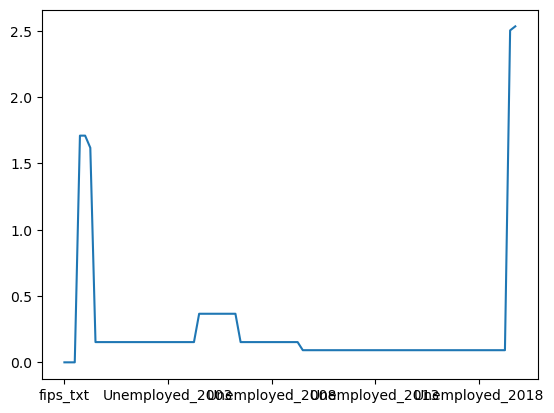

In [39]:
xemploi=df_emploi.isna().sum()/len(df_emploi)*100
xemploi.plot()

### Suppression des valeurs manquantes. 

In [40]:
df_emploi.dropna(inplace=True)

Dans la dataFrame sur l'emploi, nous avons Le nombre de la population active, le nombre de personne employée et sans emploi, puis le taux de chômage.
Nous allons donc vérifier que le taux de chômage est égale aux rapport des personnes sans emploi et de la population active.
En effet, nous n'allons garder que la colonne du taux de chômage, car cette dernière comprend les informations du nombre de personne employées ou sans emploi et 
sur la population active.
On va donc créer une fonction (fctemploi), cette fonction créera une colonne reprennant les valeurs du taux de chômage, si le taux de chômage est égale aux 
rapport entre les personnes non employées et la population active.

### Création et application de la fonction fctemploi sur les années 2018 et 2019 

In [41]:
def fctemploi (year):
    df_emploi[f'{year}']=df_emploi[f'Unemployment_rate_{year}'][((df_emploi[f'Unemployed_{year}']/df_emploi[f'Civilian_labor_force_{year}'])*100
                                                                 == df_emploi[f'Unemployment_rate_{year}'])]

In [42]:
fctemploi (2019)
fctemploi (2018)

### Visualisation des résultats de la fonction fctemploi.

In [43]:
df_emploi['2019'].unique()

array([nan, 5. , 2. , 3.2])

In [44]:
df_emploi['2018'].unique()

array([nan, 2.5, 4. ])

La visualisation des résultats, nous montre que seulement une fois dans nos 2 tests le taux de chômage n'est pas égale aux rapports entre les personnes
non employées et la population active. 
On va donc supprimer les colonnes créent par la fonction fctemploi et on va créer et appliquer la fonction "unemplsupprfonc", qui nous servira
à ne garder que le taux de chômage.

### Création et application de la fonction unemmplsupprfonc et suppression des colonnes crée par la fonction fctemploi.

In [45]:
df_emploi.drop(columns=['2018','2019'],inplace=True)

In [46]:
def unemplsupprfonc (year):
    df_emploi.drop(columns=[f"Unemployed_{year}",f"Employed_{year}",f"Civilian_labor_force_{year}"],
             inplace=True)

In [47]:
list_to_del=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
for i in list_to_del :
    unemplsupprfonc(i)

In [48]:
df_emploi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 2 to 3195
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   fips_txt                                   3129 non-null   int64  
 1   Stabr                                      3129 non-null   object 
 2   area_name                                  3129 non-null   object 
 3   Rural_urban_continuum_code_2013            3129 non-null   float64
 4   Urban_influence_code_2013                  3129 non-null   float64
 5   Metro_2013                                 3129 non-null   float64
 6   Unemployment_rate_2000                     3129 non-null   float64
 7   Unemployment_rate_2001                     3129 non-null   float64
 8   Unemployment_rate_2002                     3129 non-null   float64
 9   Unemployment_rate_2003                     3129 non-null   float64
 10  Unemployment_rate_2004  

### Suppression des autres variables qui ne nous servent pas ou qui sont déja présentent dans d'autre dataframe.

In [49]:
df_emploi.drop(columns=['Rural_urban_continuum_code_2013','Urban_influence_code_2013','Metro_2013','Med_HH_Income_Percent_of_State_Total_2019'], inplace=True)

In [50]:
df_emploi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 2 to 3195
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   fips_txt                      3129 non-null   int64  
 1   Stabr                         3129 non-null   object 
 2   area_name                     3129 non-null   object 
 3   Unemployment_rate_2000        3129 non-null   float64
 4   Unemployment_rate_2001        3129 non-null   float64
 5   Unemployment_rate_2002        3129 non-null   float64
 6   Unemployment_rate_2003        3129 non-null   float64
 7   Unemployment_rate_2004        3129 non-null   float64
 8   Unemployment_rate_2005        3129 non-null   float64
 9   Unemployment_rate_2006        3129 non-null   float64
 10  Unemployment_rate_2007        3129 non-null   float64
 11  Unemployment_rate_2008        3129 non-null   float64
 12  Unemployment_rate_2009        3129 non-null   float64
 13  Une

### FEATURE ENGINEERING df_emploi.

Maintenant que nous avons les taux de chômage de 2000 à 2019.
On va créer la variable evomoychom(16-19), cette colonne représente l'évolution du taux de chômage annuel moyen de 2016 à 2019.
Ainsi, on pourra capturer l'information de l'évolution du taux de chômage sans garder toutes les colonnes. En effet, si l'on garde 
les colonnes d'une variable pour plusieurs années, on introduit une forte autocorrélation entre ces variables.

In [51]:
df_emploi['evomoychom(16-19)']=((df_emploi['Unemployment_rate_2016']+df_emploi['Unemployment_rate_2017']
                                  +df_emploi['Unemployment_rate_2018']+df_emploi['Unemployment_rate_2019'])/4)

### Création et application de la fonction suppremp, pour supprimer les variables qui ne sont plus nécessaires après l'étape de feature engineering.

In [52]:
def suppremp (year):
    df_emploi.drop(columns=[f'Unemployment_rate_{year}'], inplace=True)

In [53]:
list_emp=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
for i in list_emp:
    suppremp (i)

### Standardisation des intitulés des colonnes qui vont fusionner lors de la concaténation des dataframes.

In [54]:
df_emploi.rename(columns={"fips_txt": "FIPS Code", "Stabr": "State",'area_name':'Area name'}, inplace=True)

### Suppression de la virgule et du code de l'états dans les valeurs de variable Area name 

In [55]:
df_emploi['Area name'].head()

2    Autauga County, AL
3    Baldwin County, AL
4    Barbour County, AL
5       Bibb County, AL
6     Blount County, AL
Name: Area name, dtype: object

In [56]:
dfpoub=df_emploi['Area name'].str.partition(', ',True)
df_emploi['Area name']= dfpoub[0]
print('Cette étape est nécessaire car lors de la concaténation, si les données de Area Name ne sont pas similaires aux autres dataframe, les dataframe ne pourront fusionner') 
df_emploi.head()

Cette étape est nécessaire car lors de la concaténation, si les données de Area Name ne sont pas similaires aux autres dataframe, les dataframe ne pourront fusionner


,FIPS Code,State,Area name,Unemployment_rate_2019,Median_Household_Income_2019,evomoychom(16-19)
2,1001,AL,Autauga County,2.7,58233.0,3.825
3,1003,AL,Baldwin County,2.7,59871.0,3.925
4,1005,AL,Barbour County,3.8,35972.0,5.750
5,1007,AL,Bibb County,3.1,47918.0,4.450
6,1009,AL,Blount County,2.7,52902.0,3.900


### Visualisation de la dataframe

In [57]:
df_emploi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 2 to 3195
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FIPS Code                     3129 non-null   int64  
 1   State                         3129 non-null   object 
 2   Area name                     3129 non-null   object 
 3   Unemployment_rate_2019        3129 non-null   float64
 4   Median_Household_Income_2019  3129 non-null   float64
 5   evomoychom(16-19)             3129 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 171.1+ KB


# Introduction de la Dataframe df_pov. 

### Insertion des données et rapide aperçu.

In [58]:
df_pov = pd.read_excel('PovertyEstimates.xls', skiprows=4)
df_pov.head()

,FIPStxt,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_2013,POVALL_2019,CI90LBALL_2019,CI90UBALL_2019,...,CI90UB517P_2019,MEDHHINC_2019,CI90LBINC_2019,CI90UBINC_2019,POV04_2019,CI90LB04_2019,CI90UB04_2019,PCTPOV04_2019,CI90LB04P_2019,CI90UB04P_2019
0,0,US,United States,NaN,NaN,NaN,NaN,39490096,39248096,39732096,...,16.0,65712,65594,65830,3457689.0,3405854.0,3509524.0,18.2,17.9,18.5
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,747478,730491,764465,...,21.6,51771,51179,52363,69236.0,65296.0,73176.0,24.2,22.8,25.6
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,6723,5517,7929,...,19.4,58233,52517,63949,NaN,NaN,NaN,NaN,NaN,NaN
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,22360,18541,26179,...,17.2,59871,54593,65149,NaN,NaN,NaN,NaN,NaN,NaN
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,5909,4787,7031,...,49.0,35972,31822,40122,NaN,NaN,NaN,NaN,NaN,NaN


Les colonnes de la DataFrame sont composées de 2 groupes de 3 colonnes. Le premier groupe de 3 colonnes représente le taux de pauvreté estimée avec un intervalle de confiance à 90%, ainsi que la borne haute et basse de cette estimation. Ensuite, il y'à un deuxième groupe de 3 colonnes qui est composé des mêmes valeurs,
mais en pourcentage. 
Avec cette disposition en 2 groupes de 3 colonnes, notre DataFrame représente :
la pauvreté totale (ligne 7 à 12), 
la pauvreté des personnes de 0 à 17 ans (ligne 13 à 18),
la pauvreté des personnes 5 à 17 ans (ligne 19 à 24),
La pauvreté pour les enfants de 0-4 (ligne 28 à 33),
Les lignes 25 à 28 représentent l'estimation du revenu moyen, et les estimations hautes et basses avec un intervalle de confiance de 90% .

<AxesSubplot: >

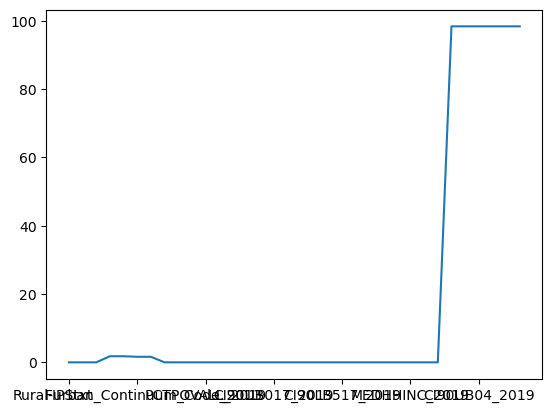

In [59]:
### Visualisation des valeurs manquantes 
x=df_pov.isna().sum()/len(df_pov)*100
x.plot()

On voit que pour le groupe de colonne représentant la pauvreté chez les enfant de 0 à 4 contient des taux de valeurs manquantes de 98%, on suprrimera ces données,
comme celle sur la pauvreté des enfants de 5 à 17 ans et de 0 à 17 ans.
On ne va donc garder que les données concernant la pauvreté totale.

### Suppression des données concernant la pauvreté des enfants 0 à 4 ans, de 5 à 17 ans et de 0 à 17 ans.

In [60]:
def sup3groupe (norm,pourc):
    df_pov.drop(columns=[f"CI90LB{norm}",f"CI90UB{norm}",f"POV{norm}",f"CI90UB{pourc}",f"CI90LB{pourc}",f"PCTPOV{norm}"], inplace=True)

In [61]:

sup3groupe ('04_2019','04P_2019')
sup3groupe ('517_2019','517P_2019')
sup3groupe ('017_2019','017P_2019')

### Suppression des variables qui ne sont pas en pourcentage, pour garder les mêmes en pourcentage.

In [62]:
def supnonpct (norm):
    df_pov.drop(columns=[f"CI90LB{norm}",f"CI90UB{norm}",f"POV{norm}"], inplace=True)  

In [63]:
supnonpct('ALL_2019')

### Suppression des valeurs manquantes. 

In [64]:
df_pov.dropna(inplace=True)

On a donc supprimé les données manquantes, les colonnes en pourcentage, aisni que celle que l'on n'utilisera pas.
On va créer une fonction pour montrer que les estimations sont ègales à la moyenne des bornes hautes et basse de ces estimations.

### Suppression des bornes hautes et basses des estimations. 

On crée une fonction (comppct) qui reprend l'estimation du taux de pauvreté, si le taux de pauvreté est égale à la moyenne de la borne haute et basse de son 
estimation. Ainsi, on pourra vérifier si la condition de la fonction est respectée.

In [65]:
def comppct (year,pct):
    df_pov[f'{year}']=df_pov[f'PCTPOV{year}'][((df_pov[f'CI90LB{pct}']+df_pov[f'CI90UB{pct}'])/2 == df_pov[f'PCTPOV{year}'])]

In [66]:
comppct('ALL_2019','ALLP_2019')

en appliquant la fonction .unique() à la colonne créer par la fonction comppct, on remarque qu'une seule fois la condition de la fonction comppct n'est pas
respectée. On peut donc supprimer les colonnes des bornes hautes et basses, car la moyenne de ces bornes est le pourcentage de pauvreté

In [67]:
df_pov['ALL_2019'].unique()

array([ nan, 27.1, 20.3, 16.3, 30. , 21.6, 17.2, 19.6, 15.9, 16. , 22.6,
       18.4, 16.6, 13.3, 15. , 14.6, 22.2, 17.1, 16.8, 12.2, 18.1, 26. ,
       18.2, 20.5, 18.8, 17. , 16.1, 19.4, 15.3, 15.7, 17.7, 15.5, 12. ,
       26.6, 11.5, 24.8, 16.9, 23.3, 33.9, 24.3, 17.5, 18.9, 11.2,  6.2,
       36.4, 17.4, 16.2, 17.3, 18.6, 32.5, 14.8,  7.6,  9.5, 23.5,  9.8,
        6.6,  7.2,  6.3, 10.4,  9.4,  7.1,  9.6, 20.7, 11.4, 24. ,  8.1,
        8.6, 14.7, 24.4, 33.4, 21.1, 20.1,  9.3, 22.1, 25.2, 14. , 12.1,
       20.4, 18.5, 12.7,  8.9, 15.1, 22.9, 15.4, 31. , 20.6, 14.1, 13.7,
       21.2, 15.6, 18.3, 22.4, 25.4, 25.5, 35.4, 17.8, 10.7, 16.4, 23. ,
       19.9, 24.1, 16.5, 33.3, 23.1, 20.2, 32. , 19.3, 17.9,  8.7, 19.1,
       22. , 11.7, 19. , 13.4, 17.6,  6.9, 10.1, 12.6,  7.4, 13.2, 11.3,
       10.3, 11.6,  6.1,  9. , 13. , 12.8,  8.2, 15.2, 10.8,  4.1, 11. ,
       24.6, 40. , 11.8,  2.7,  7.9,  5.7,  8.8, 20. , 13.5, 12.9, 14.9,
       11.9, 24.2,  9.9,  6.4,  7. ,  7.8, 21. , 12

### Suppression de la colonne cée par la fonction comppct.

In [68]:
df_pov.drop(columns=['ALL_2019'],inplace=True)

### Création et application de la fonction supborne pour supprimer les bornes hautes et basses.

In [69]:
def supborne (year): 
    df_pov.drop(columns=[f"CI90LB{year}",f"CI90UB{year}"], inplace=True)

In [70]:
supborne ('INC_2019')
supborne ('ALLP_2019')

### Suppression des variables présentes dans d'autres dataframe. 

In [71]:
df_pov.drop(columns=['MEDHHINC_2019','Rural-urban_Continuum_Code_2003','Urban_Influence_Code_2003','Rural-urban_Continuum_Code_2013','Urban_Influence_Code_2013'], 
            inplace=True)

### Standardisation des intitulés des colonnes qui vont fusionner lorsque l'on va concaténer nos dataframes

In [72]:
df_pov.rename(columns={"FIPStxt": "FIPS Code", "Stabr": "State",'Area_name':'Area name'}, inplace=True)

In [73]:
df_pov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3136 entries, 2 to 3192
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FIPS Code       3136 non-null   int64  
 1   State           3136 non-null   object 
 2   Area name       3136 non-null   object 
 3   PCTPOVALL_2019  3136 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 122.5+ KB


Notre étude consistant à prédire les gagnants des villes aux prochains votes, nous utiliserons le code postal le nom de l'aire urbaine de l'états pour fusionner lors de la concatéation de nos données.

# CONCATENATION DES DATAFRAMES

Notre étude consistant à prédire le parti gagnant des villes lors des prochains votes, nous utiliserons le code postal, le nom de l'aire urbaine et de l'états
pour fusionner lors de la concaténation de nos données.

In [74]:
df1=pd.merge(df_pop,df_pov, on=['FIPS Code','State','Area name'])

In [75]:
df2=pd.merge(df1,df_emploi, on=['FIPS Code','State','Area name'])

In [76]:
df21=pd.merge(df2,df_educ, on=['FIPS Code','State','Area name'])

In [77]:
df=pd.merge(df21,df_2020, on=['FIPS Code','Area name'])

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3086 entries, 0 to 3085
Data columns (total 22 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   FIPS Code                                                                 3086 non-null   int64  
 1   State                                                                     3086 non-null   object 
 2   Area name                                                                 3086 non-null   object 
 3   POP_ESTIMATE_2019                                                         3086 non-null   int64  
 4   R_NATURAL_INC_2019                                                        3086 non-null   float64
 5   R_INTERNATIONAL_MIG_2019                                                  3086 non-null   float64
 6   R_DOMESTIC_MIG_2019                                             

# Feature Engineering (calcul participation brute)

Nous permet d'insérer des informations concernant l'intérêt porté à l'éléction.

In [79]:
df['participation']=(df['total_votes']/df['POP_ESTIMATE_2019'])*100

In [80]:
df[['participation','POP_ESTIMATE_2019','total_votes']].head()

,participation,POP_ESTIMATE_2019,total_votes
0,49.705561,55869,27770
1,49.131853,223234,109679
2,42.607146,24686,10518
3,42.846298,22394,9595
4,47.708643,57826,27588


In [81]:
df.drop(columns=['POP_ESTIMATE_2019','total_votes'],inplace=True)

# Compréhension des données

### Statistiques récapitulatives

In [82]:
df.describe(include=np.number)

,FIPS Code,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2019,R_DOMESTIC_MIG_2019,EVO_DOMESTIC_MIG_16-19,EVO_INT_MIG_16-19,EVO_NATURAL_INC_16-19,PCTPOVALL_2019,Unemployment_rate_2019,Median_Household_Income_2019,evomoychom(16-19),2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",participation
count,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000,3086.000000
mean,30696.587816,0.518873,0.618859,-0.232887,-0.401383,0.891062,0.583583,14.477155,3.959851,55515.365846,4.452722,5.002268,5.242385,13.075712,34.182139,30.824204,21.917945,49.548183
std,14988.143061,3.899352,1.399054,12.449306,10.403941,1.708916,3.844369,5.789453,1.391320,14337.017508,1.503467,2.697438,3.470024,6.258072,7.203081,5.209632,9.521108,8.464676
min,1001.000000,-13.540491,-1.735609,-165.250965,-108.696123,-1.694202,-13.761232,2.700000,0.700000,24732.000000,1.700000,1.000000,1.000000,1.116910,7.265136,5.235602,0.000000,14.504447
25%,19043.500000,-1.999506,0.000000,-5.937951,-6.049794,0.011889,-1.898329,10.500000,3.000000,46179.000000,3.425000,2.000000,2.000000,8.479117,29.733608,27.298263,15.322934,44.255256
50%,29218.000000,0.279390,0.208647,-0.698532,-1.268292,0.377807,0.256741,13.400000,3.700000,53216.500000,4.200000,6.000000,5.000000,11.736493,34.562586,30.810162,19.554257,49.583270
75%,46012.500000,2.677858,0.755546,5.482374,4.692812,1.067795,2.729003,17.500000,4.600000,61771.750000,5.175000,7.000000,8.000000,16.702550,39.117895,34.225865,25.875350,55.058369
max,56045.000000,24.429062,26.041667,126.182965,82.689731,31.688980,24.745699,47.700000,18.300000,151806.000000,20.200000,9.000000,12.000000,73.560211,57.433674,60.563381,77.557411,98.309493


In [83]:
df_num_features = df.select_dtypes(include=np.number)

df_num_features.drop(columns=['FIPS Code'],inplace=True)

### Visualisation des Distributions 

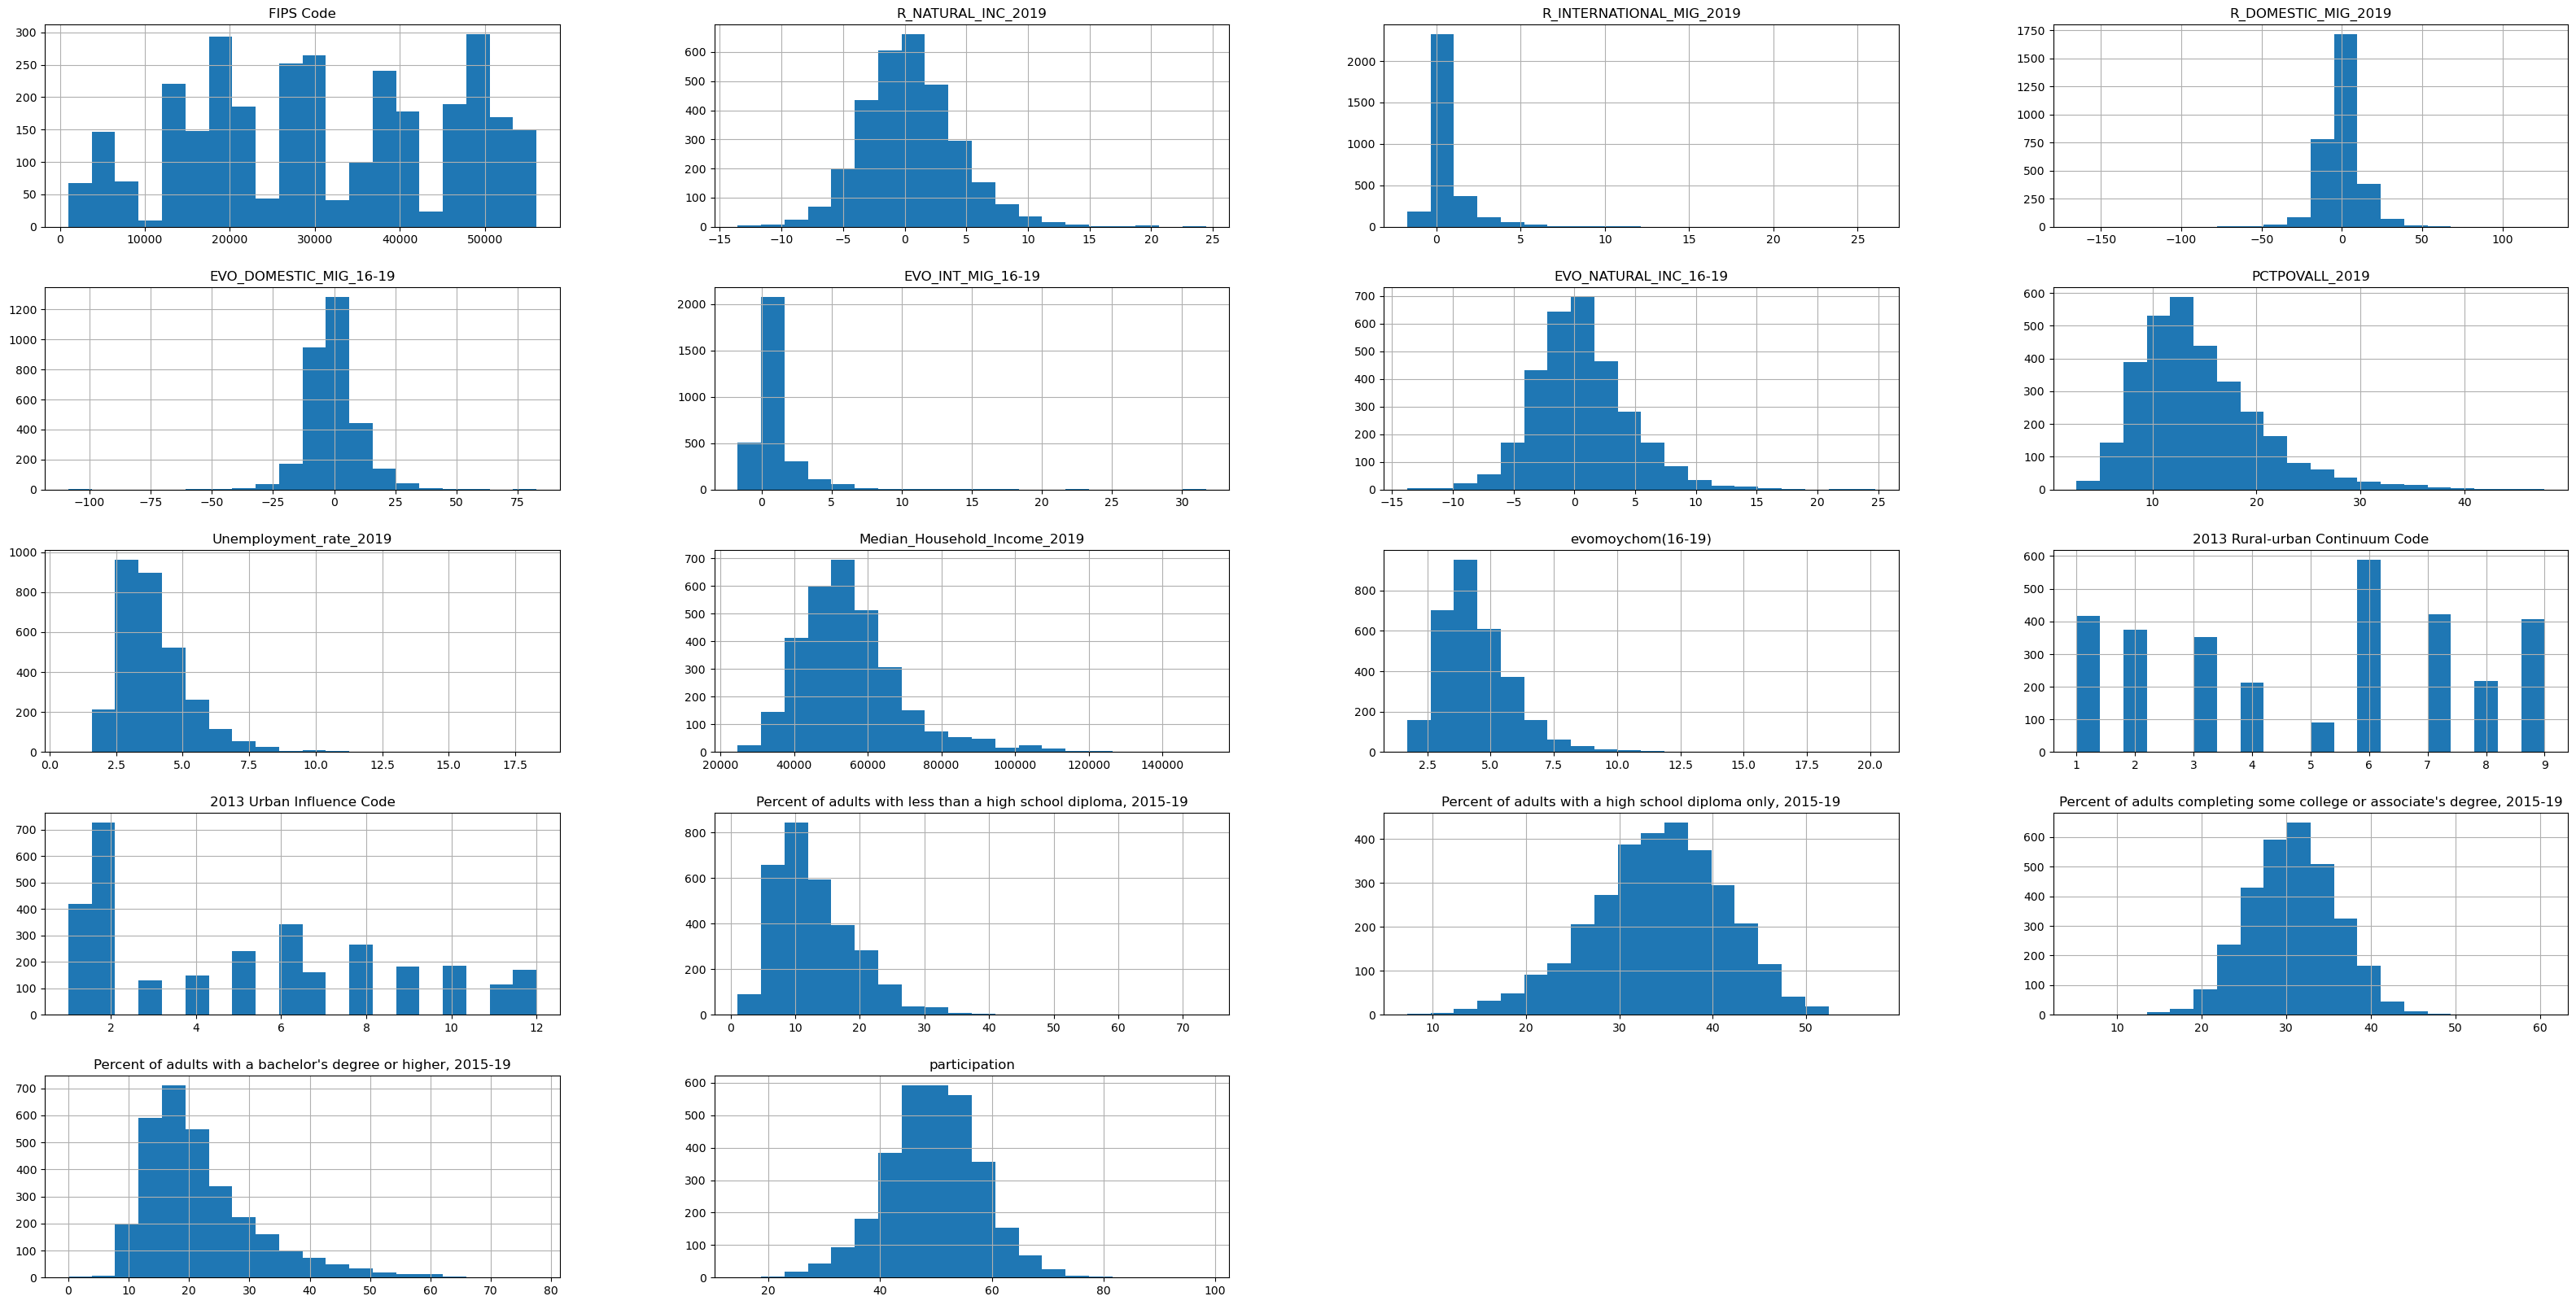

In [84]:
df.hist(figsize = (40, 20), bins = 20)
plt.show()

### Test de Shapiro

In [85]:
def shap_test (df):
    w, p = stats.shapiro(df)
 
    alpha = 0.05
 
    print(w, p) 
 
    if p > alpha:
        print(f'Hypothèse H0 ne peut pas être rejetée. Il ne y a pas suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.\n')
    else:
        print(f'Hypothèse H0 est rejetée. Il y a suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.\n')

In [86]:
x=df.drop(columns=['FIPS Code','State','Area name','target']).columns

In [87]:
for i in x: 
    shap_test (df[i])

0.9811503291130066 7.740042728992906e-20
Hypothèse H0 est rejetée. Il y a suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.

0.5910802483558655 0.0
Hypothèse H0 est rejetée. Il y a suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.

0.8917430639266968 3.6279617241369514e-42
Hypothèse H0 est rejetée. Il y a suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.

0.9383813738822937 5.228828002020449e-34
Hypothèse H0 est rejetée. Il y a suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.

0.5975842475891113 0.0
Hypothèse H0 est rejetée. Il y a suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.

0.9789628386497498 5.553732637946509e-21
Hypothèse H0 est rejetée. Il y a suffisamment de preuves pour dire que les données ne sont pas distribuées normalement.

0.9344713687896729 7.450532873266838e-35
Hypothèse H0 est rejet

### Visualisation des corrélations.

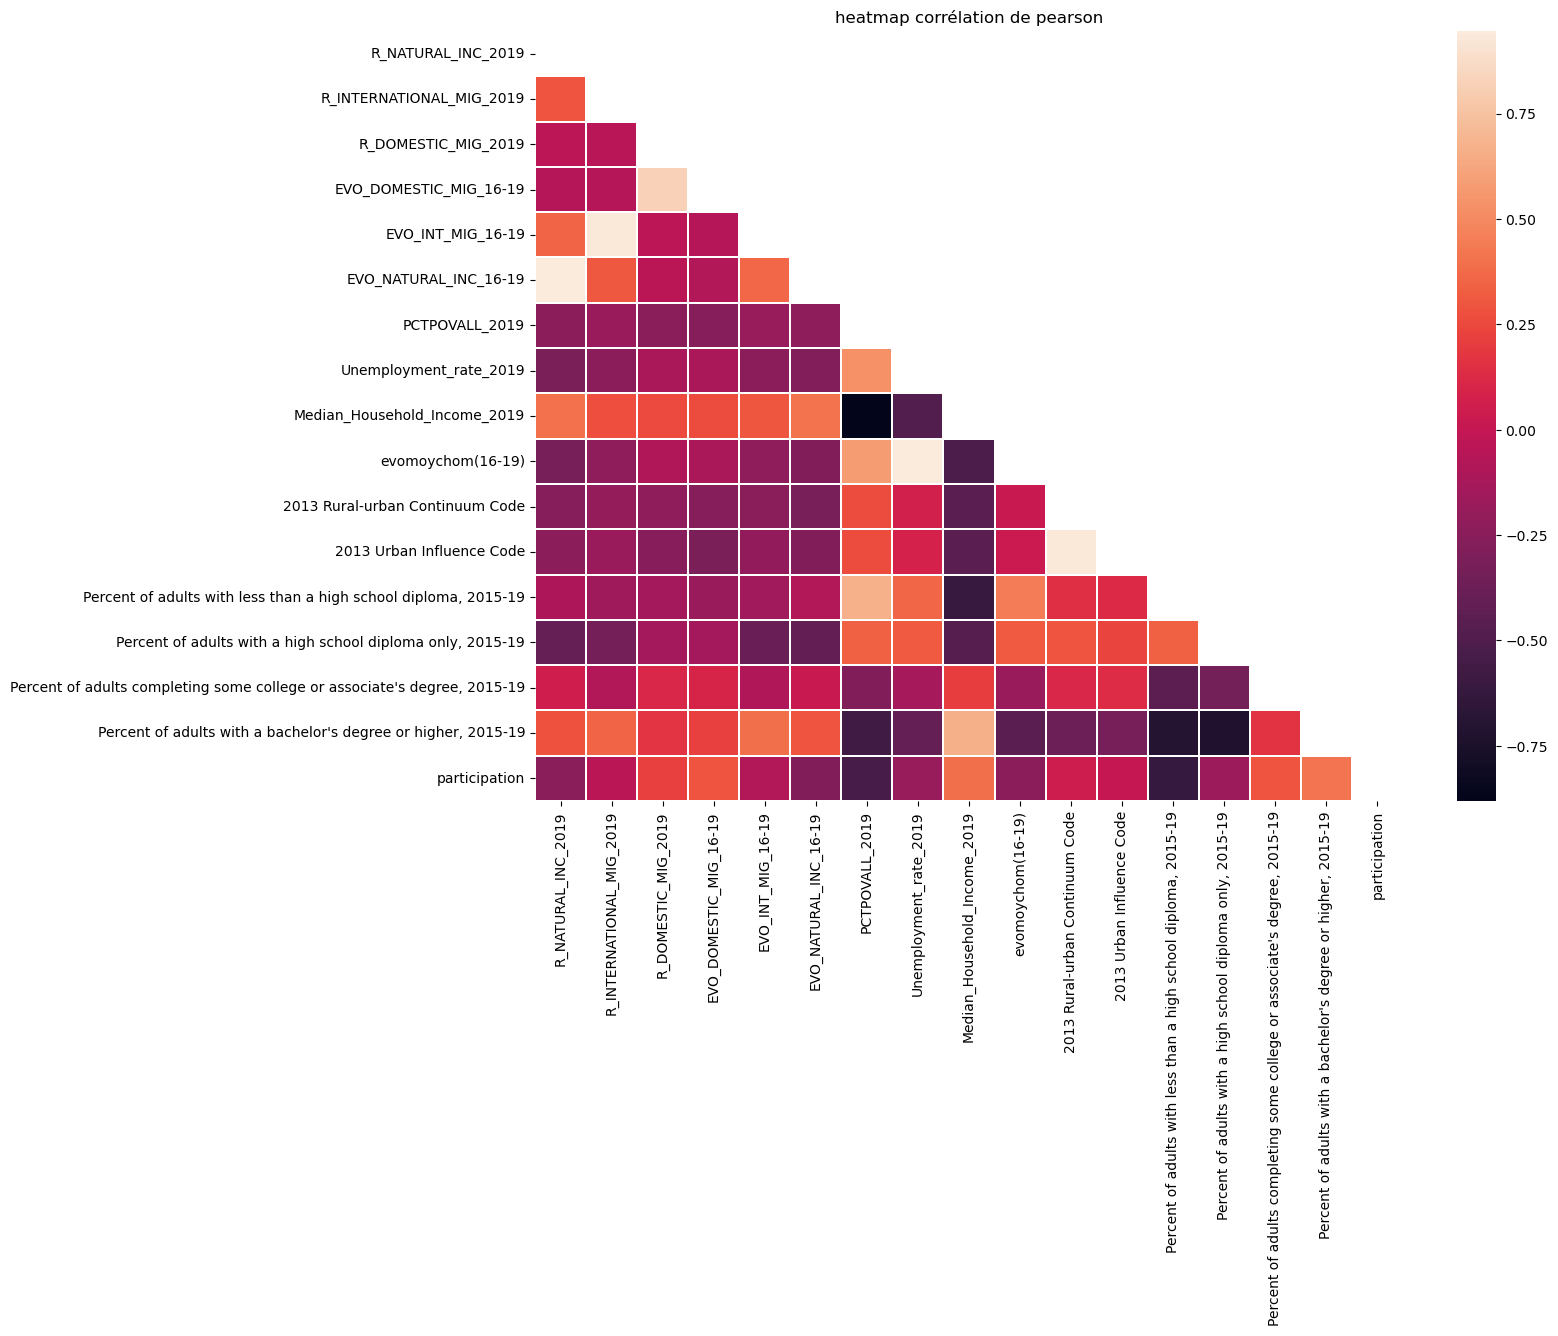

In [88]:
### Heatmap des corrélations. 
corr=df_num_features.corr(method='spearman')
mask=np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True 

fig1, ax = plt.subplots(figsize=(14,10))
ax=sns.heatmap(corr, mask=mask, linewidths=0.05)
ax.set_title('heatmap corrélation de pearson')
plt.show()

### Détection des corrélations supérieur à un seuil de 0.75

In [89]:
def detect_corr (corr,seuil):
    tmp=[]
    for i in range(len(corr.columns.values)):
        A=corr.loc[:,corr.columns.values[i]]
        for j in range (i) :
            if(abs(A[j])>=seuil) and (A.index[j] != corr.columns.values[i]):
                tmp.append((corr.columns.values[i], A.index[j], A[j]))
    corr_tab=pd.DataFrame(tmp,columns =['var_1','var_2','corr_seuil_val_absolu'])        
    return corr_tab

In [90]:
detect_corr (corr,0.75)

,var_1,var_2,corr_seuil_val_absolu
0,EVO_DOMESTIC_MIG_16-19,R_DOMESTIC_MIG_2019,0.818754
1,EVO_INT_MIG_16-19,R_INTERNATIONAL_MIG_2019,0.926976
2,EVO_NATURAL_INC_16-19,R_NATURAL_INC_2019,0.946048
3,Median_Household_Income_2019,PCTPOVALL_2019,-0.881142
4,evomoychom(16-19),Unemployment_rate_2019,0.940836
5,2013 Urban Influence Code,2013 Rural-urban Continuum Code,0.927031


A un seuil de 75% de corrélation, nous identifions des corrélations principalement entre les variables issues du feature engineering et des variables d'origine.
On va donc garder les variables issues du feature engineering.
Parmi les autres corrélations fortes, il y'a une corrélation entre Revenu médian et le taux de pauvreté. On va donc supprimer le revenu médian, car le taux 
de pauvreté comprend le coût de la vie contrairement au revenu médian.

### Suppression des variables corrélées.

In [91]:
df_num_features.drop(columns=['R_DOMESTIC_MIG_2019','R_NATURAL_INC_2019','Median_Household_Income_2019',
                              'Unemployment_rate_2019','2013 Rural-urban Continuum Code','R_INTERNATIONAL_MIG_2019'], inplace=True)

In [92]:
df.drop(columns=['R_DOMESTIC_MIG_2019','R_NATURAL_INC_2019','Median_Household_Income_2019',
                              'Unemployment_rate_2019','2013 Rural-urban Continuum Code','R_INTERNATIONAL_MIG_2019'], inplace=True)

### Vérification suite à la suppression des variables correlées.

In [93]:
corr1=df_num_features.corr(method='spearman')
detect_corr(corr1,0.75)

,var_1,var_2,corr_seuil_val_absolu


# Réprésentation des valeurs abérrantes.

### Calcul de l'écart interquartile.

In [94]:
Q1 = df_num_features.quantile(0.25)
Q3 = df_num_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

EVO_DOMESTIC_MIG_16-19                                                      10.742606
EVO_INT_MIG_16-19                                                            1.055906
EVO_NATURAL_INC_16-19                                                        4.627332
PCTPOVALL_2019                                                               7.000000
evomoychom(16-19)                                                            1.750000
2013 Urban Influence Code                                                    6.000000
Percent of adults with less than a high school diploma, 2015-19              8.223433
Percent of adults with a high school diploma only, 2015-19                   9.384287
Percent of adults completing some college or associate's degree, 2015-19     6.927602
Percent of adults with a bachelor's degree or higher, 2015-19               10.552417
participation                                                               10.803113
dtype: float64


### Recherche de valeur abérantes.

In [95]:
outlierdf= pd.DataFrame((df_num_features < (Q1 - 1.5 * IQR)) | (df_num_features > (Q3 + 1.5 * IQR)))
for i in outlierdf.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlierdf[outlierdf[i] == True][i]))))

Total number of Outliers in column EVO_DOMESTIC_MIG_16-19 are 155
Total number of Outliers in column EVO_INT_MIG_16-19 are 273
Total number of Outliers in column EVO_NATURAL_INC_16-19 are 75
Total number of Outliers in column PCTPOVALL_2019 are 89
Total number of Outliers in column evomoychom(16-19) are 93
Total number of Outliers in column 2013 Urban Influence Code are 0
Total number of Outliers in column Percent of adults with less than a high school diploma, 2015-19 are 64
Total number of Outliers in column Percent of adults with a high school diploma only, 2015-19 are 33
Total number of Outliers in column Percent of adults completing some college or associate's degree, 2015-19 are 26
Total number of Outliers in column Percent of adults with a bachelor's degree or higher, 2015-19 are 147
Total number of Outliers in column participation are 50


### Visualisation des valeurs abérantes. 

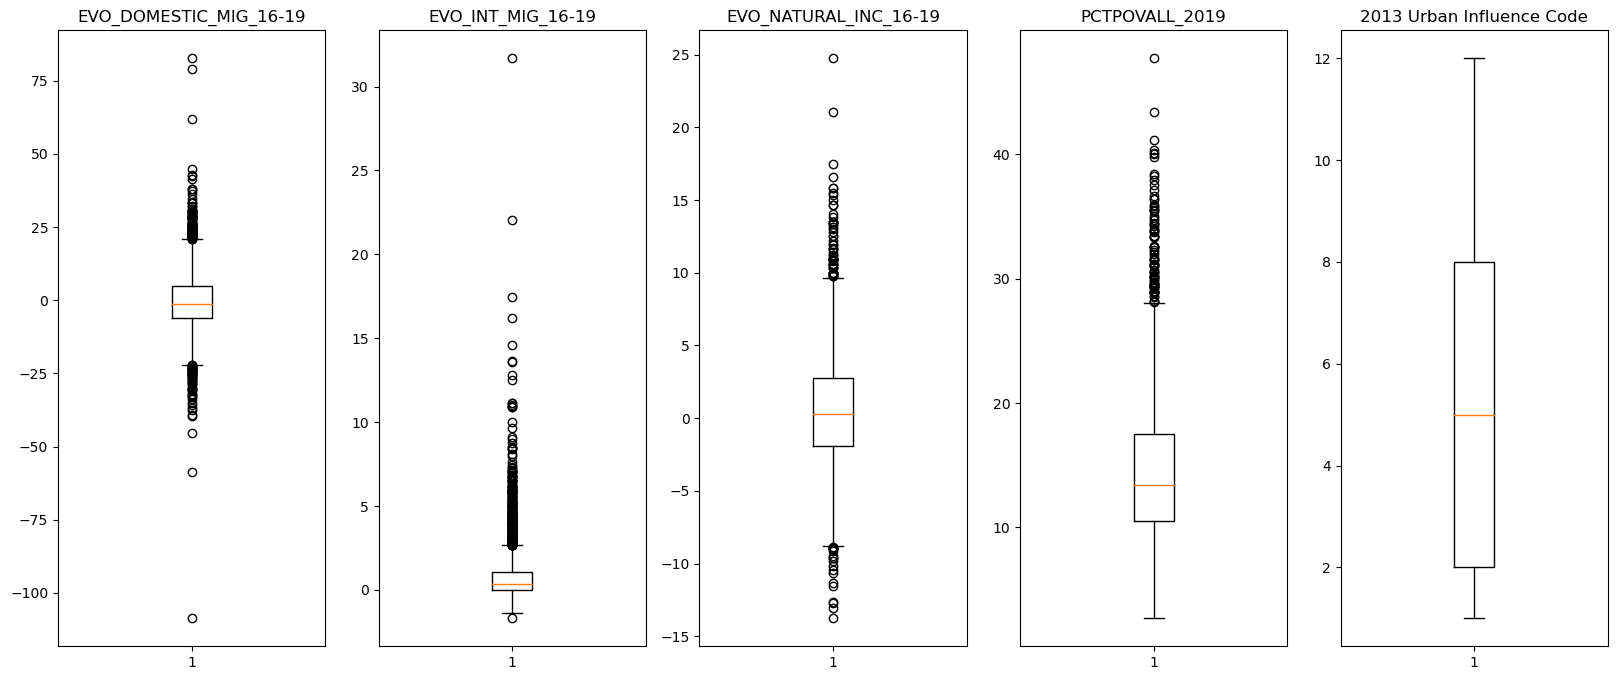

In [96]:
fig, ax  = plt.subplots(1,5, figsize = (20, 8))

ax[0].boxplot(df["EVO_DOMESTIC_MIG_16-19"])
ax[0].set_title("EVO_DOMESTIC_MIG_16-19")

ax[1].boxplot(df["EVO_INT_MIG_16-19"])
ax[1].set_title("EVO_INT_MIG_16-19")

ax[2].boxplot(df["EVO_NATURAL_INC_16-19"])
ax[2].set_title("EVO_NATURAL_INC_16-19")

ax[3].boxplot(df["PCTPOVALL_2019"])
ax[3].set_title("PCTPOVALL_2019")

ax[4].boxplot(df["2013 Urban Influence Code"])
ax[4].set_title("2013 Urban Influence Code")

plt.show()

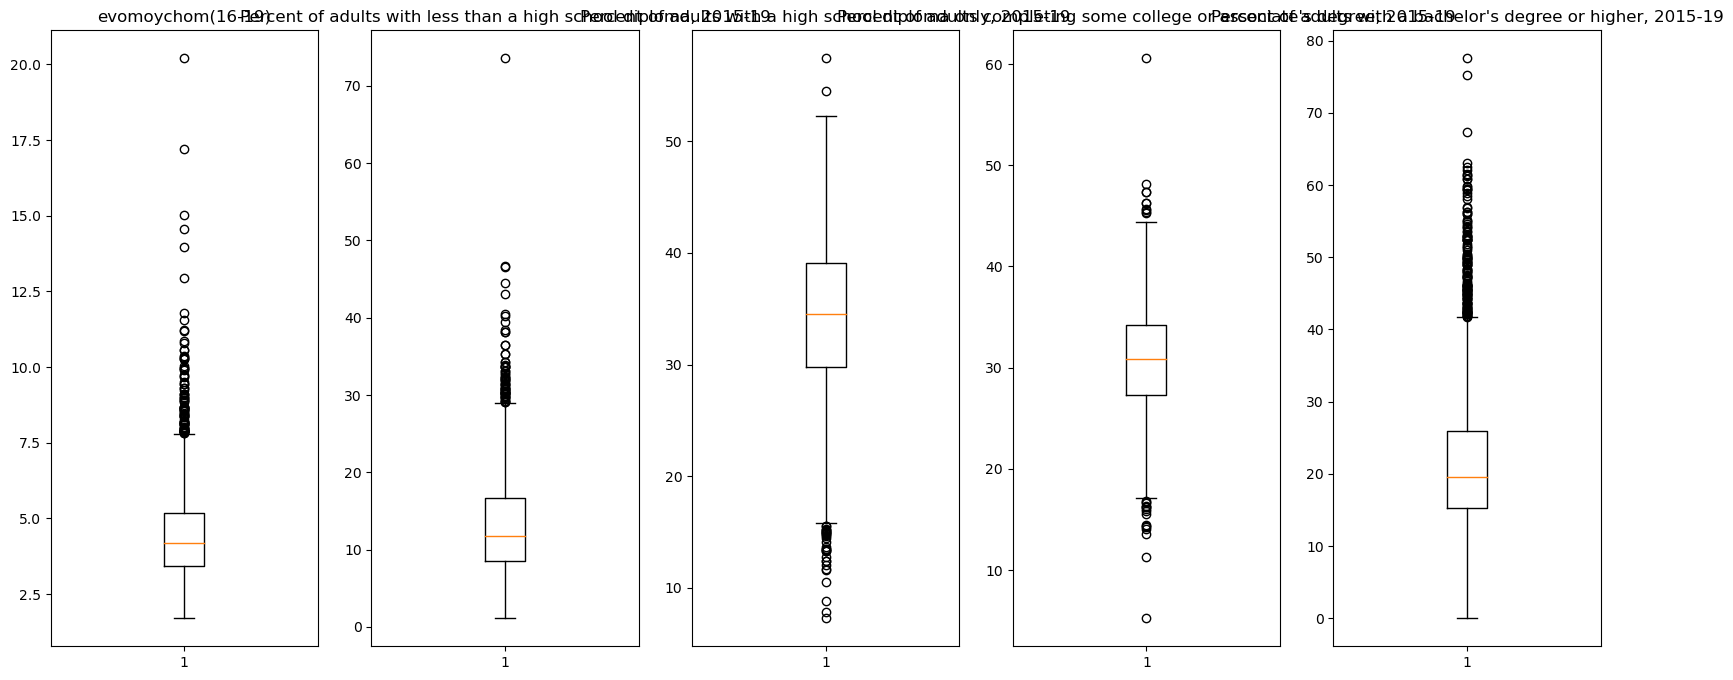

In [97]:
fig, ax  = plt.subplots(1,5, figsize = (20, 8))

ax[0].boxplot(df['evomoychom(16-19)'])
ax[0].set_title("evomoychom(16-19)")

ax[1].boxplot(df["Percent of adults with less than a high school diploma, 2015-19"])
ax[1].set_title("Percent of adults with less than a high school diploma, 2015-19")

ax[2].boxplot(df["Percent of adults with a high school diploma only, 2015-19"])
ax[2].set_title("Percent of adults with a high school diploma only, 2015-19")

ax[3].boxplot(df["Percent of adults completing some college or associate's degree, 2015-19"])
ax[3].set_title("Percent of adults completing some college or associate's degree, 2015-19")

ax[4].boxplot(df["Percent of adults with a bachelor's degree or higher, 2015-19"])
ax[4].set_title("Percent of adults with a bachelor's degree or higher, 2015-19")

plt.show()

# Feature Scaling 

En présence de données non équilibrées et avec des échelles de grandeurs différentes. Nous allons Standardiser nos données afin d'égaliser les ordres
de grandeurs au sein de nos variables. Ceci, permettra d'avoir une meilleure interprétation des coéfficients, d'amoindrir l'effet des valeurs aberrantes 
et améliorer la convergence de nos algorithmes.

### Application de la standardisation via Standard scaler. 

In [98]:
scaler=StandardScaler()
scaler.fit(df_num_features)
df_scal=scaler.transform(df_num_features)

### Création d'une DataFrame standardisée.

In [99]:
df_scal=pd.DataFrame(df_scal, columns=[['EVO_DOMESTIC_MIG_16-19','EVO_INT_MIG_16-19','EVO_NATURAL_INC_16-19',
      'PCTPPOVALL_2019','evomoychom(16-19)','2013_Urban Influence Code','Percent of adults with less than a high school diploma, 2015-19','Percent of adults with a high school diploma only, 2015-19',
      "Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",
       "participation"]])

### écart interquartile des données standardisées.

In [100]:
Q1_scal = df_scal.quantile(0.25)
Q3_scal = df_scal.quantile(0.75)
IQR_scal = Q3_scal - Q1_scal
print(IQR_scal)

EVO_DOMESTIC_MIG_16-19                                                      1.032719
EVO_INT_MIG_16-19                                                           0.617981
EVO_NATURAL_INC_16-19                                                       1.203860
PCTPPOVALL_2019                                                             1.209291
evomoychom(16-19)                                                           1.164165
2013_Urban Influence Code                                                   1.729375
Percent of adults with less than a high school diploma, 2015-19             1.314265
Percent of adults with a high school diploma only, 2015-19                  1.303027
Percent of adults completing some college or associate's degree, 2015-19    1.329984
Percent of adults with a bachelor's degree or higher, 2015-19               1.108498
participation                                                               1.276465
dtype: float64


### écart interquartile des données non standardisées pour comparer. 

In [101]:
print(IQR)

EVO_DOMESTIC_MIG_16-19                                                      10.742606
EVO_INT_MIG_16-19                                                            1.055906
EVO_NATURAL_INC_16-19                                                        4.627332
PCTPOVALL_2019                                                               7.000000
evomoychom(16-19)                                                            1.750000
2013 Urban Influence Code                                                    6.000000
Percent of adults with less than a high school diploma, 2015-19              8.223433
Percent of adults with a high school diploma only, 2015-19                   9.384287
Percent of adults completing some college or associate's degree, 2015-19     6.927602
Percent of adults with a bachelor's degree or higher, 2015-19               10.552417
participation                                                               10.803113
dtype: float64


On peut très facilement apercevoir les effets du scaling. En effet, les données standardisées présentent un écart interquartile beaucoup plus faibles. 
Les données sont donc plus centrées autour de la moyenne.  
Le standard scaling permet une convergence plus rapide des algorithme, notamment sur la regréssion logistique et le Support Vector Machine (SVM).

Note : Dans la partie modélisation nous appliquerons le standard scaler via un pipeline, nous n'utiliserons pas df_scal qui est une dataframe uniquement destiné à montrer les effets de standard scaler sur la distribution.  

## Visualisation de la répartition de notre target et du nombre d'observations par états 

In [102]:
data_cat_features=df[['State','Area name','target']]

Text(0.5, 0, 'états')

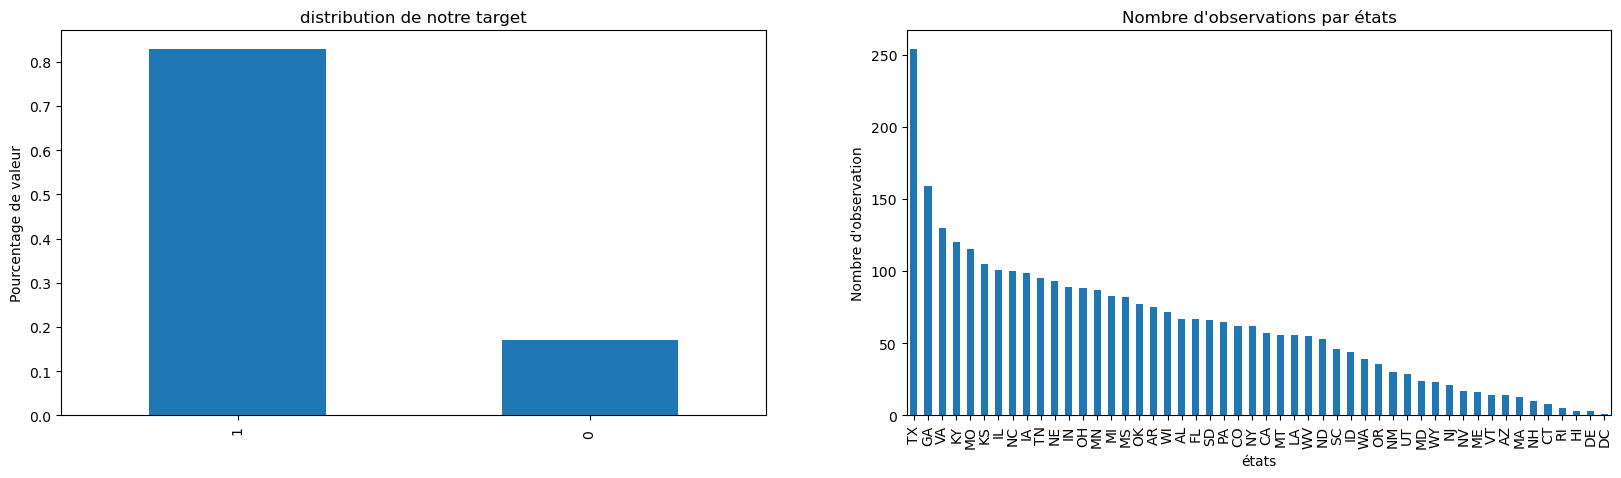

In [103]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5)) 
data_cat_features['target'].value_counts(normalize=True).plot(kind='bar',ax=ax[0])
ax[0].set_title('distribution de notre target')
ax[0].set_ylabel('Pourcentage de valeur')
data_cat_features['State'].value_counts().plot(kind='bar',ax=ax[1])
ax[1].set_title("Nombre d'observations par états")
ax[1].set_ylabel("Nombre d'observation")
ax[1].set_xlabel("états")

# Séparation des données 

### Définition de la target et des variables explicatives. 

In [104]:
y=df['target']
X=df.drop(columns=['FIPS Code','State','Area name','target'])

### Séparation des données sans prise en compte du déséquilibre dans les classes de notre target 

In [105]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, random_state=1)

In [106]:
y_train1.value_counts(normalize=True)

1     0.835494
0     0.164506
Name: target, dtype: float64

### Séparation des données avec prise en compte du déséquilibre dans les classes de notre target. 

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [108]:
y_train.value_counts(normalize=True)

1     0.829417
0     0.170583
Name: target, dtype: float64

### Représentation de la répartition d'origine des classes de notre target. 

In [109]:
y.value_counts(normalize=True)

1     0.829553
0     0.170447
Name: target, dtype: float64

On voit que l'utilisation de la fonction stratify Y, permet d'effectuer un train_test_split en conservant la répartition de notre target au sein de nos
échantillons.

# Modélisation et évaluation. 

## param_grid 

In [110]:
random_state=48

In [111]:
Random_state=42

param_grid_log = {'logistic__C': np.logspace(-3,0,3,7),
                  'logistic__class_weight': np.linspace(0.0,0.99,100)}

param_grid_svc = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}

param_grid_dt={'classifier__max_depth':[5,10,20,50],
               'classifier__min_samples_split':[5,10,20,30],
               'classifier__min_weight_fraction_leaf':[0.05,0.1,0.5]}

param_grid_rf={'classifier__max_features':[1,3,10],
               'classifier__min_samples_split':[2,3,10],
               'classifier__criterion':['gini'],
               'classifier__n_estimators':[100,200,300]}

param_grid_xgb={'classifier__n_estimators': [100,200,300],
                'classifier__max_depth':[3,6,9,12],
                'classifier__learning_rate':[0.01,0.03,0.05,0.1]}

In [112]:
# Régression logistique avec Pipeline 

Comme on l'a vu la distribution des classes de notre target sont déséquilibré. 
Nous allons donc choisir dans notre régression logistique le paramètre class_weight='balanced', pour signifier que nos données sont déséquilibrés. 
Ainsi, notre grid search est composé du paramètre Class weight, qui permet d'obtenir le meilleur hyperparamètre pour pondérer le poids de nos différentes classes 
et ainsi supprimer des classes déséquilibrées. 

### Sélection de variable. 

In [113]:
log_reg=LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train.values.ravel())

In [114]:
x=rfe.ranking_
selection=pd.DataFrame(x, index=['EVO_DOMESTIC_MIG_16-19','EVO_INT_MIG_16-19','EVO_NATURAL_INC_16-19','PCTPOVALL_2019','evomoychom(16-19)','2013 Urban Influence Code',
                            'percent of aduts with a high school diploma only, 2015-19 ','percent of aduts with less than a high school diploma, 2015-19',
                            "percent of aduts completing some college or associate's degree, 2015-19",
                            "percent of aduts with a bachelor's degree or higher, 2015-19",'participation'])
selection

,0
EVO_DOMESTIC_MIG_16-19,1
EVO_INT_MIG_16-19,1
EVO_NATURAL_INC_16-19,1
PCTPOVALL_2019,1
evomoychom(16-19),1
2013 Urban Influence Code,1
"percent of aduts with a high school diploma only, 2015-19",1
"percent of aduts with less than a high school diploma, 2015-19",1
"percent of aduts completing some college or associate's degree, 2015-19",1
"percent of aduts with a bachelor's degree or higher, 2015-19",2


### Mise en place du pipeline de la régression logistique avec gridsearchCV

In [115]:
scaler=StandardScaler()
logistic= LogisticRegression(max_iter=1000, class_weight='balanced')

pipe_logreg= Pipeline (steps=[('scaler',scaler), ('logistic',logistic)])
   
pipe_logreg_gscv = GridSearchCV(pipe_logreg, param_grid_log, n_jobs=5)

pipe_logreg_gscv.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=5,
             param_grid={'logistic__C': array([0.001     , 0.03162278, 1.        ]),
                         'logistic__class_weight': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.2....29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])})

### Fine tuning des hyperparamètres

In [116]:
pipe_logreg_gscv.best_params_

{'logistic__C': 1.0, 'logistic__class_weight': 0.0}

### Pipeline avec fine tuning

In [117]:
scaler=StandardScaler()
logistic= LogisticRegression(max_iter=1000, C=1, class_weight=0)  ###  voir version(9)(16) pour retrouver paramètre avant. 
pipe_logreg_fine = Pipeline(steps=[('scaler',scaler), ('logistic',logistic)])

pipe_logreg_fine.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(C=1, class_weight=0, max_iter=1000))])

### Prédiction de la régression logistique et évaluation 

In [118]:
y_train_pred=pipe_logreg_fine.predict(X_train)
y_test_pred=pipe_logreg_fine.predict(X_test)

y_cross=cross_val_predict(pipe_logreg_fine,X,y,cv=5,n_jobs=5)
scorecross=f1_score(y,y_cross, average='weighted')
crosstrain=cross_val_score(pipe_logreg_fine,X,y,cv=5, scoring='f1_weighted')

print(f"le score F1 lors de l'entrainement du modèle est : {f1_score(y_train,y_train_pred, average='weighted')}")
print(f"le score F1 obtenu lors de l'application du modèle \npréalablement entrainé avec X_train et appliqué à X_test est : {f1_score(y_test,y_test_pred,average='weighted')}")

print ("\nComme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,")
print (f"en utilisant cette méthode on obtient un score f1 de {scorecross} \nlors des différends entrainement les scores sont  de {crosstrain}") 

le score F1 lors de l'entrainement du modèle est : 0.8900705956618545
le score F1 obtenu lors de l'application du modèle 
préalablement entrainé avec X_train et appliqué à X_test est : 0.898030826614009

Comme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,
en utilisant cette méthode on obtient un score f1 de 0.8873692674879966 
lors des différends entrainement les scores sont  de [0.89396891 0.87110134 0.90589817 0.89877735 0.8661726 ]


Le modèle semble ne pas effectuer de sur-apprentissage ou de sous-apprentissage lors de son entrainement, que ce soit par un entrainement simple avec X_train 
ou que ce soit par cross validation, notre modèle logistique avec fine tuning des hyperparamètres, est donc capable de se généraliser.  

### Matrice de confusion du modèle de régression logistique avec fine tuning des hyperparamètres et crossvalidation. 

              precision    recall  f1-score   support

          0        0.77      0.55      0.64       526
           1       0.91      0.97      0.94      2560

    accuracy                           0.89      3086
   macro avg       0.84      0.76      0.79      3086
weighted avg       0.89      0.89      0.89      3086



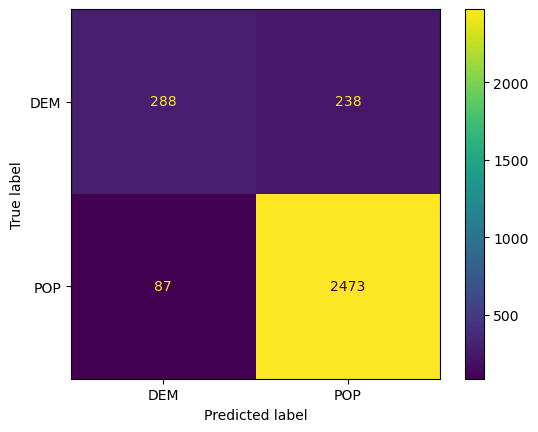

In [119]:
print(classification_report(y,y_cross))
cm=confusion_matrix(y,y_cross)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DEM','POP'])
_=disp.plot()

In [120]:
x=logistic.coef_
coef=pd.DataFrame(x, columns=['EVO_DOMESTIC_MIG_16-19','EVO_INT_MIG_16-19','EVO_NATURAL_INC_16-19','PCTPOVALL_2019','evomoychom(16-19)','2013 Urban Influence Code',
                              'percent of aduts with a high school diploma only, 2015-19 ','percent of aduts with less than a high school diploma, 2015-19',
                              "percent of aduts completing some college or associate's degree, 2015-19",
                              "percent of aduts with a bachelor's degree or higher, 2015-19",'participation'])
coef

,EVO_DOMESTIC_MIG_16-19,EVO_INT_MIG_16-19,EVO_NATURAL_INC_16-19,PCTPOVALL_2019,evomoychom(16-19),2013 Urban Influence Code,"percent of aduts with a high school diploma only, 2015-19","percent of aduts with less than a high school diploma, 2015-19","percent of aduts completing some college or associate's degree, 2015-19","percent of aduts with a bachelor's degree or higher, 2015-19",participation
0,0.558274,-0.324904,-0.276005,-1.321352,-0.380353,0.76542,0.068591,0.872694,0.273984,-0.853949,-0.830753


# Modèle SVC

### Mise en place du pipeline SVC avec gridsearchCV

In [121]:
steps=[('scaler',StandardScaler()), ('SVM',SVC())]
pipe_svm=Pipeline(steps)

pipe_svm_gscv = GridSearchCV(pipe_svm, param_grid=param_grid_svc, cv=5)

pipe_svm_gscv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.001, 0.1, 10, 100, 1000000.0],
                         'SVM__gamma': [0.1, 0.01]})

### Fine tuning des hyperparamètres

In [122]:
pipe_svm_gscv.best_params_

{'SVM__C': 100, 'SVM__gamma': 0.01}

### Pipeline SVC avec les hyperparamètres optimisés.

In [123]:
steps = [('scaler', StandardScaler()), ('SVM', SVC(C=10,gamma=0.1))]
pipe_svm = Pipeline(steps)
pipe_svm.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('SVM', SVC(C=10, gamma=0.1))])

### Prédiction SVC et évaluation 

In [124]:
y_train_pred=pipe_svm.predict(X_train)
y_test_pred=pipe_svm.predict(X_test)

y_cross=cross_val_predict(pipe_svm,X,y,cv=5,n_jobs=5)
scorecross=f1_score(y,y_cross, average='weighted')
crosstrain=cross_val_score(pipe_svm,X,y,cv=5, scoring='f1_weighted')

print(f"le score F1 lors de l'entrainement du modèle est : {f1_score(y_train,y_train_pred, average='weighted')}")
print(f"le score F1 obtenu lors de l'application du modèle \npréalablement entrainé avec X_train et appliqué à X_test est : {f1_score(y_test,y_test_pred,average='weighted')}")

print ("\nComme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,")
print (f"en utilisant cette méthode on obtient un score f1 de {scorecross} \nlors des différends entrainement les scores sont de {crosstrain}") 

le score F1 lors de l'entrainement du modèle est : 0.955413347812806
le score F1 obtenu lors de l'application du modèle 
préalablement entrainé avec X_train et appliqué à X_test est : 0.9044565739695435

Comme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,
en utilisant cette méthode on obtient un score f1 de 0.8893738188005456 
lors des différends entrainement les scores sont de [0.88117473 0.89516403 0.90094539 0.89434679 0.87519528]


En analysant les résultats de nos prédictions, on s'aperçoit que le modèle sur-apprend lorsqu'il est entrainé via X_train, ce sur-apprentissage est effacé lorsque
l'on effectue des prévisions via la technique de la validation croisée. En effectuant, une validation croisée sur notre modèle SVC, on augmente donc la capacité 
du modèle à se généraliser

### Matrice de confusion du modèle SVC avec fine tuning des hyperparamètre et crossvalidation. 

              precision    recall  f1-score   support

          0        0.73      0.60      0.66       526
           1       0.92      0.95      0.94      2560

    accuracy                           0.89      3086
   macro avg       0.82      0.78      0.80      3086
weighted avg       0.89      0.89      0.89      3086



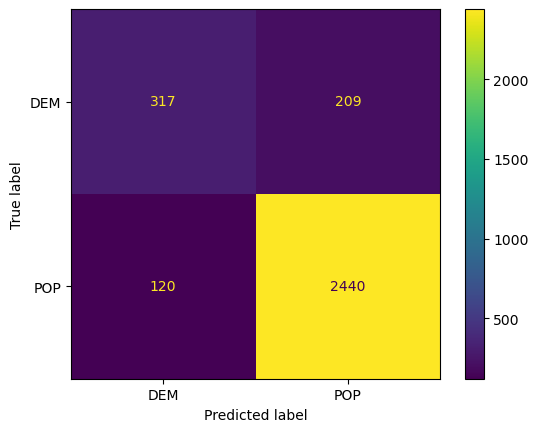

In [125]:
print(classification_report(y,y_cross))
cm=confusion_matrix(y,y_cross)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DEM','POP'])
_=disp.plot()

# Decision Tree (DT)

Contrairement aux modèles de classification logistique et SVC, les modèles basés sur les arbres de décisions ne nécessitent pas de feature scaling.

### Mise en place du pipeline DT (Decision Tree)

In [126]:
clf=DecisionTreeClassifier(random_state=random_state)
pipe=Pipeline([('classifier',clf)])

pipe_gscv=GridSearchCV(pipe, param_grid=param_grid_dt, cv=3, n_jobs=5)

pipe_gscv.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(random_state=48))]),
             n_jobs=5,
             param_grid={'classifier__max_depth': [5, 10, 20, 50],
                         'classifier__min_samples_split': [5, 10, 20, 30],
                         'classifier__min_weight_fraction_leaf': [0.05, 0.1,
                                                                  0.5]})

### Séléction de variable.

In [127]:
sel=SelectFromModel(DecisionTreeClassifier(random_state=random_state))
sel.fit(X_train, y_train)

SelectFromModel(estimator=DecisionTreeClassifier(random_state=48))

In [128]:
selection=X_train.columns[(sel.get_support())]
print (f" Il y'a { len(selection)}")
print(f"Voici leur liste : {selection}") 

 Il y'a 4
Voici leur liste : Index(['EVO_DOMESTIC_MIG_16-19', 'PCTPOVALL_2019', 'evomoychom(16-19)',
       'Percent of adults with a bachelor's degree or higher, 2015-19'],
      dtype='object')


### Fine tuning des hyperparamètres du modèle DT. 

In [129]:
pipe_gscv.best_params_

{'classifier__max_depth': 5,
 'classifier__min_samples_split': 5,
 'classifier__min_weight_fraction_leaf': 0.05}

### Pipeline DT avec les hyperparamètres optimisés.

In [130]:
### Mise en place du Pipeline avec les hyperparamètres optimisés.
clf=DecisionTreeClassifier(max_depth=5,
                           min_samples_split=5,
                           min_weight_fraction_leaf=0.1,
                           random_state=random_state)
pipe_dt=Pipeline([('classifier',clf)])
pipe_dt.fit(X_train,y_train)

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_split=5,
                                        min_weight_fraction_leaf=0.1,
                                        random_state=48))])

### Prédiction DT et évaluation 

In [131]:
y_train_pred=pipe_dt.predict(X_train)
y_test_pred=pipe_dt.predict(X_test)

y_cross=cross_val_predict(pipe_dt,X,y,cv=5,n_jobs=5)
scorecross=f1_score(y,y_cross, average='weighted')
crosstrain=cross_val_score(pipe_dt,X,y,cv=5, scoring='f1_weighted')

print(f"le score F1 lors de l'entrainement du modèle est : {f1_score(y_train,y_train_pred, average='weighted')}")
print(f"le score F1 obtenu lors de l'application du modèle \n préalablement entrainé avec X_train et appliqué à X_test est : {f1_score(y_test,y_test_pred,average='weighted')}")

print ("\nComme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillon X_train et y_train,")
print (f"en utilisant cette méthode on obtient un score f1 de {scorecross} \nlors des différends entrainement, les scores sont de {crosstrain}") 

le score F1 lors de l'entrainement du modèle est : 0.859039483550469
le score F1 obtenu lors de l'application du modèle 
 préalablement entrainé avec X_train et appliqué à X_test est : 0.860236688031127

Comme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillon X_train et y_train,
en utilisant cette méthode on obtient un score f1 de 0.8577852493407423 
lors des différends entrainement, les scores sont de [0.85021005 0.87510121 0.84830125 0.85019885 0.86475812]


Le modèle Decision tree ne semble pas être sujet à un sur-apprentissage ou à un sous-apprentissage, on considère donc que ce dernier peut se généraliser. 

### Matrice de confusion du modèle DT avec fine tuning des hyperparamètre et crossvalidation. 

              precision    recall  f1-score   support

          0        0.64      0.49      0.55       526
           1       0.90      0.94      0.92      2560

    accuracy                           0.87      3086
   macro avg       0.77      0.71      0.74      3086
weighted avg       0.85      0.87      0.86      3086



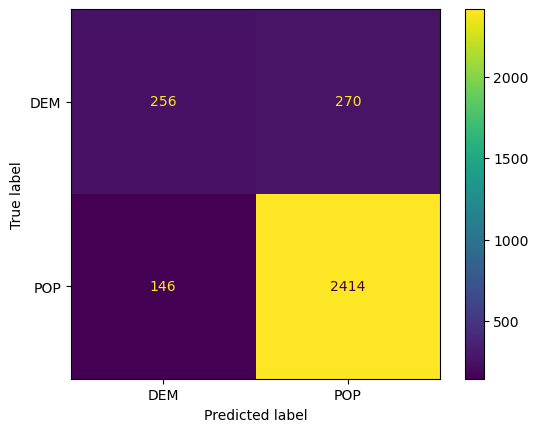

In [132]:
print (classification_report(y,y_cross))
cm=confusion_matrix(y,y_cross)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DEM','POP'])
_=disp.plot()

### Analyse de l'importance des variables globales.

In [133]:
_ = pipe_dt.fit(X_train,y_train)

In [134]:
col_names = X_train.columns
features_importances = pipe_dt.named_steps['classifier'].feature_importances_
forest_importances=pd.Series(features_importances, index=col_names)

Text(0, 0.5, 'mean decrease in impurity')

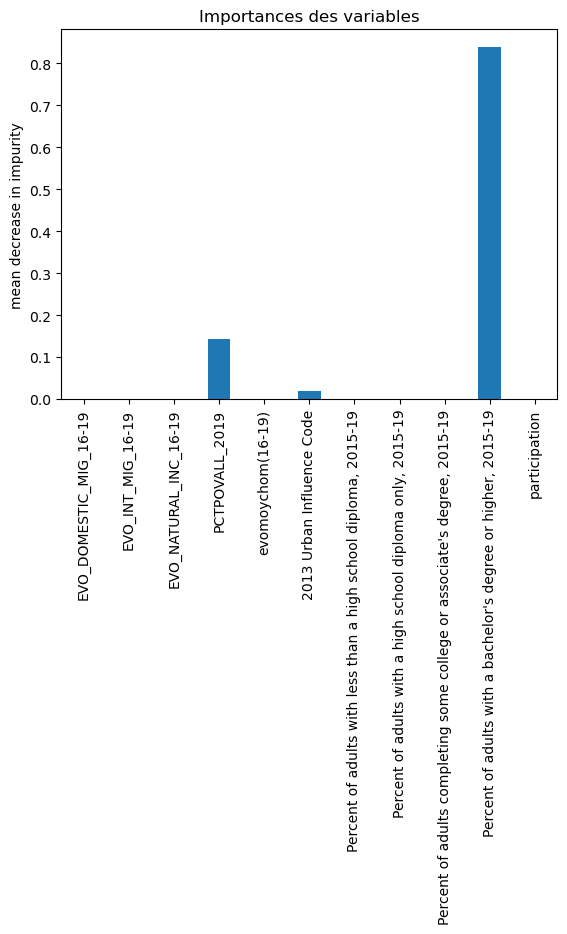

In [135]:
fig, ax =plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title('Importances des variables')
ax.set_ylabel('mean decrease in impurity')

### Analyse de l'importance des variables local.

# Random Forest (RF)

### Séléction de variable.

In [136]:
import pandas as pd
from sklearn.feature_selection import SelectFromModel

In [137]:
sel=SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [138]:
selection=X_train.columns[(sel.get_support())]
print (f" Il y'a { len(selection)}")
print(f"Voici leur liste : {selection}") 

 Il y'a 4
Voici leur liste : Index(['EVO_INT_MIG_16-19', 'PCTPOVALL_2019',
       'Percent of adults with a high school diploma only, 2015-19',
       'Percent of adults with a bachelor's degree or higher, 2015-19'],
      dtype='object')


### Mise en place du pipeline RF. 

In [139]:
clf=RandomForestClassifier(random_state=random_state)
pipe_rf=Pipeline([('classifier',clf)])

pipe_rf=GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=3, n_jobs=5)

pipe_rf.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=48))]),
             n_jobs=5,
             param_grid={'classifier__criterion': ['gini'],
                         'classifier__max_features': [1, 3, 10],
                         'classifier__min_samples_split': [2, 3, 10],
                         'classifier__n_estimators': [100, 200, 300]})

### Fine tuning des hyperparamètres du modèle RF. 

In [140]:
pipe_rf.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_features': 3,
 'classifier__min_samples_split': 3,
 'classifier__n_estimators': 200}

### Pipeline RF avec les hyperparamètres optimisés.

In [141]:
### Mise en place du pipeline
clf=RandomForestClassifier(n_estimators=300, 
                           criterion='gini',
                           min_samples_split=3,
                           max_features=3)
pipe_rf_tuned=Pipeline([('classifier',clf)])
pipe_rf_tuned.fit(X_train,y_train)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_features=3, min_samples_split=3,
                                        n_estimators=300))])

### Prédiction RF et évaluation 

In [142]:
y_train_pred=pipe_rf_tuned.predict(X_train)
y_test_pred=pipe_rf_tuned.predict(X_test)

y_cross=cross_val_predict(pipe_rf_tuned,X,y,cv=5,n_jobs=5)
scorecross=f1_score(y,y_cross, average='weighted')
crosstrain=cross_val_score(pipe_rf_tuned,X,y,cv=5, scoring='f1_weighted')

print(f"le score F1 lors de l'entrainement du modèle est : {f1_score(y_train,y_train_pred, average='weighted')}")
print(f"le score F1 obtenu lors de l'application du modèle \n préalablement entrainé avec X_train et appliqué à X_test est : {f1_score(y_test,y_test_pred,average='weighted')}")

print ("\nComme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,")
print (f"en utilisant cette méthode on obtient un score f1 de {scorecross} \nlors des différends entrainement les scores sont de {crosstrain}") 

le score F1 lors de l'entrainement du modèle est : 1.0
le score F1 obtenu lors de l'application du modèle 
 préalablement entrainé avec X_train et appliqué à X_test est : 0.9001761489003802

Comme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,
en utilisant cette méthode on obtient un score f1 de 0.8883982195076653 
lors des différends entrainement les scores sont de [0.88409507 0.88592478 0.90494535 0.87250318 0.87870806]


Notre modèle random forest avec les hyperparamètres optimisés s'adapte complètement aux données d'apprentissage, ce modèle effectue donc du sur-apprentissage.
Cet effet de sur-apprentissage disparait lors de la cross validation.

### Matrice de confusion du modèle Random Forest avec fine tuning des hyperparamètre avec crossvalidation. 

              precision    recall  f1-score   support

          0        0.76      0.56      0.65       526
           1       0.91      0.96      0.94      2560

    accuracy                           0.89      3086
   macro avg       0.84      0.76      0.79      3086
weighted avg       0.89      0.89      0.89      3086



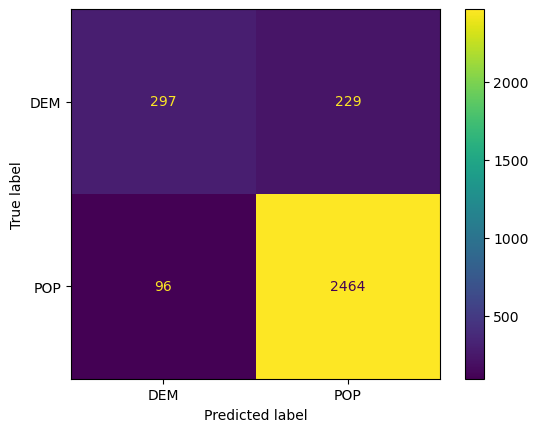

In [144]:
print (classification_report(y,y_cross))
cm=confusion_matrix(y,y_cross)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DEM','POP'])
_=disp.plot()

### Analyse de l'importance des variables du modèle random forest.

In [145]:
_ = pipe_rf_tuned.fit(X_train,y_train)

In [146]:
col_names = X_train.columns
features_importances = pipe_rf_tuned.named_steps['classifier'].feature_importances_
forest_importances=pd.Series(features_importances, index=col_names)

Text(0, 0.5, 'mean decrease in impurity')

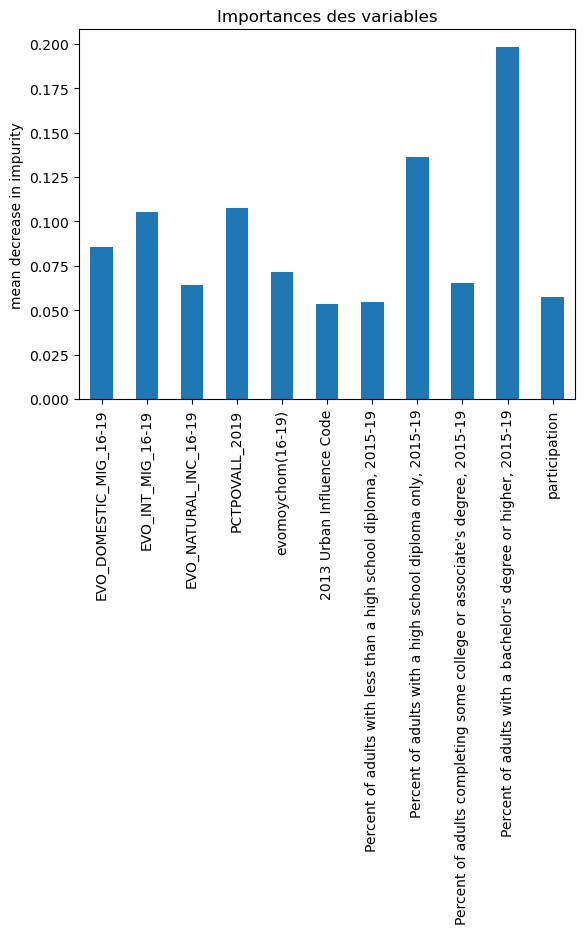

In [147]:
fig, ax =plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title('Importances des variables')
ax.set_ylabel('mean decrease in impurity')

# Gradient Boosting. 

### Mise en place du pipeline gradient boosting. 

In [148]:
gb_clf=GradientBoostingClassifier(random_state=random_state)
pipe_xgb=Pipeline([('classifier',gb_clf)])

pipe_xgb_gscv=GridSearchCV(pipe_xgb, param_grid=param_grid_xgb, cv=3, n_jobs=5)

pipe_xgb_gscv.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        GradientBoostingClassifier(random_state=48))]),
             n_jobs=5,
             param_grid={'classifier__learning_rate': [0.01, 0.03, 0.05, 0.1],
                         'classifier__max_depth': [3, 6, 9, 12],
                         'classifier__n_estimators': [100, 200, 300]})

### Séléction de variable. 

In [149]:
sel=SelectFromModel(gb_clf)
sel.fit(X_train, y_train)

SelectFromModel(estimator=GradientBoostingClassifier(random_state=48))

In [150]:
selection=X_train.columns[(sel.get_support())]
print (f" Il y'a { len(selection)} variables séléctionnées.")
print(f"Voici leur liste : {selection}") 

 Il y'a 4 variables séléctionnées.
Voici leur liste : Index(['EVO_DOMESTIC_MIG_16-19', 'PCTPOVALL_2019',
       'Percent of adults with a high school diploma only, 2015-19',
       'Percent of adults with a bachelor's degree or higher, 2015-19'],
      dtype='object')


### Fine tuning des hyperparamètres du modèle gradient boosting. 

In [151]:
pipe_xgb_gscv.best_params_

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 6,
 'classifier__n_estimators': 200}

### Pipeline gradient boosting avec les hyperparamètres optimisés.

In [152]:
xgbgood=GradientBoostingClassifier(learning_rate=0.1,max_depth=6,n_estimators=200)
pipe_gbcgood=Pipeline([('classifier',xgbgood)])
pipe_gbcgood.fit(X_train,y_train)

Pipeline(steps=[('classifier',
                 GradientBoostingClassifier(max_depth=6, n_estimators=200))])

### Prédiction gradient boosting et évaluation 

In [153]:
y_train_pred=pipe_gbcgood.predict(X_train)
y_test_pred=pipe_gbcgood.predict(X_test)

y_cross=cross_val_predict(pipe_gbcgood,X,y,cv=5,n_jobs=5)
scorecross=f1_score(y,y_cross, average='weighted')
crosstrain=cross_val_score(pipe_gbcgood,X,y,cv=5, scoring='f1_weighted')

print(f"le score F1 lors de l'entrainement du modèle est : {f1_score(y_train,y_train_pred, average='weighted')}")
print(f"le score F1 obtenu lors de l'application du modèle \n préalablement entrainé avec X_train et appliqué à X_test est : {f1_score(y_test,y_test_pred,average='weighted')}")

print ("\nComme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,")
print (f"en utilisant cette méthode on obtient un score f1 de {scorecross} \n lors des différends entrainement les score sont de {crosstrain}") 

le score F1 lors de l'entrainement du modèle est : 1.0
le score F1 obtenu lors de l'application du modèle 
 préalablement entrainé avec X_train et appliqué à X_test est : 0.8996544106586523

Comme on l'a vu la cross validation permet d'effectuer des prédictions en entrainant le modèle sur plusieurs échantillons X_train et y_train,
en utilisant cette méthode on obtient un score f1 de 0.8832402596504664 
 lors des différends entrainement les score sont de [0.88191693 0.88520984 0.90138843 0.88360241 0.87091155]


Comme le modèle random forest le modèle gradient boosting s'adapte complètement aux données d'apprentissage et effectue du sur-apprentissage.
Cet effet de sur-apprentissage disparait lors de la cross validation.

### Analyse de l'importance des variables gradient boosting.

In [154]:
_ = pipe_gbcgood.fit(X_train,y_train)

In [155]:
col_names = X_train.columns
features_importances = pipe_gbcgood.named_steps['classifier'].feature_importances_
forest_importances=pd.Series(features_importances, index=col_names)

Text(0, 0.5, 'mean decrease in impurity')

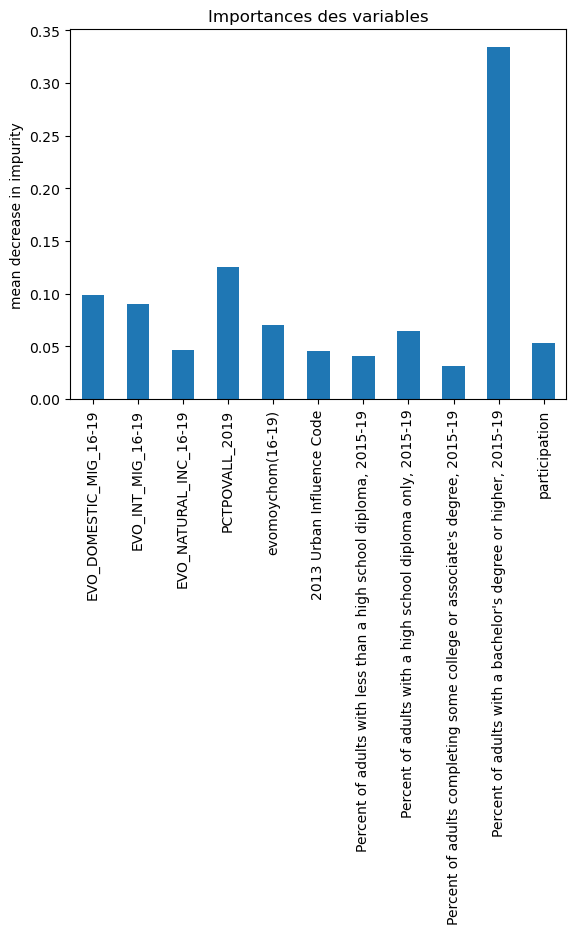

In [156]:
fig, ax =plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title('Importances des variables')
ax.set_ylabel('mean decrease in impurity')